#GAN Related Function


In [ ]:
##MOunt to drive:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Research/MachineLearningCapacity/GAN_Models

%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Research/MachineLearningCapacity/GAN_Models
 original/                              trained_generator2   trained_generator7
 Random_Data_1260_epoch_200_lenet5.h5   trained_generator3   trained_generator8
'Saved Data'/                           trained_generator4   trained_generator9
 trained_generator0                     trained_generator5
 trained_generator1                     trained_generator6


In [ ]:
from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt
import math
import itertools
import imageio
import natsort
from glob import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import tensorflow as tf
import keras
import copy
from torch.utils.data import TensorDataset, DataLoader



# define networks:
nc = 1
nz = 100
ngf = 32
ndf = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class G_net(nn.Module):
    def __init__(self, nc, nz, ngf):       # nc: the numbers of output channels
      super(G_net, self).__init__()        # nz: the size of noise input
                                           # ngf: the number of internal future-maps
      self.network = nn.Sequential(

          nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(ngf*4),
          nn.ReLU(True),

          nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(ngf*2),
          nn.ReLU(True),

          nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),

          nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
      )

    def forward(self, input):
      return self.network(input)

class D_net(nn.Module):
    def __init__(self, nc, ndf):             # nc: input channels
        super(D_net, self).__init__()        # ndf: number of internal future-maps

        self.network = nn.Sequential(

                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),

                nn.Sigmoid()
            )

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)


# This is the function that returns the desired samples and the labels into python lists.


def generate_sample(background_class, num_of_samples):
  netG = G_net(nc, nz, ngf).to(device)
  netG.load_state_dict(torch.load('trained_generator'+str(background_class)))

  image_batch = netG(torch.randn(num_of_samples,nz,1,1 , device=device))

  Labels = num_of_samples*[background_class]

  return image_batch.reshape(image_batch.shape[0], 28, 28).tolist(), Labels




#Generate GAN Images

In [ ]:
# Input the desired background class and the number of desired samples.


image_batch, Labels = generate_sample(background_class=2, num_of_samples=10)
print("{} images are in a {}. Also the labels are in a {}".format(len(image_batch), type(image_batch), type(Labels)))

10 images are in a <class 'list'>. Also the labels are in a <class 'list'>


In [ ]:
print(len(Labels))

10


#Visualize the gan Generated *Samples*

2


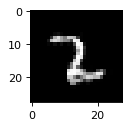

In [ ]:
plt.figure(figsize=(1.5, 1.5), dpi=80)
plt.imshow(image_batch[2], cmap="gray", vmin=0, vmax=1)
print(Labels[2])

# Preparing Training and Test Data

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import copy
import random
random.seed(10)


mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test,y_test) = mnist.load_data()



print(x_train.shape)
print(type(x_train))
print(y_train.shape)


unique, counts = np.unique(y_train, return_counts=True)
result = np.column_stack((unique, counts))
print("Before Spliting:")
print (result)



TEST_BASELINE_X=[]
TEST_BASELINE_Y=[]
train_DATA_X=[]
train_DATA_Y=[]


array=[0,0,0,0,0,0,0,0,0,0]

count = x_test.shape[0]
for i in range(count):
  num = y_test[i]
  if(array[num]<1000):
    TEST_BASELINE_X.append(x_test[i])
    TEST_BASELINE_Y.append(y_test[i])
    array[num]+=1
  else:
    train_DATA_X.append(x_test[i])
    train_DATA_Y.append(y_test[i])


count = x_train.shape[0]
for i in range(count):
  num = y_train[i]
  if(array[num]<1000):
      TEST_BASELINE_X.append(x_train[i])
      TEST_BASELINE_Y.append(y_train[i])
      array[num]+=1
  else:
    train_DATA_X.append(x_train[i])
    train_DATA_Y.append(y_train[i])



TEST_BASELINE_X = np.array(TEST_BASELINE_X)
TEST_BASELINE_Y = np.array(TEST_BASELINE_Y)
train_DATA_X = np.array(train_DATA_X)
train_DATA_Y = np.array(train_DATA_Y)




indices = np.random.permutation(train_DATA_Y.shape[0])
np.random.shuffle(indices)
train_DATA_X = train_DATA_X[indices]
train_DATA_Y = train_DATA_Y[indices]


unique, counts = np.unique(train_DATA_Y, return_counts=True)
result = np.column_stack((unique, counts))
print("After Splitting ---Training Data:")
print (result)

print("After Splitting ---Test Data:")
unique, counts = np.unique(TEST_BASELINE_Y, return_counts=True)
result = np.column_stack((unique, counts))
print (result)


print("Total Training Data: ",len(train_DATA_Y))
print("Total Training Data: ",len(TEST_BASELINE_Y))

(60000, 28, 28)
<class 'numpy.ndarray'>
(60000,)
Before Spliting:
[[   0 5923]
 [   1 6742]
 [   2 5958]
 [   3 6131]
 [   4 5842]
 [   5 5421]
 [   6 5918]
 [   7 6265]
 [   8 5851]
 [   9 5949]]
After Splitting ---Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
After Splitting ---Test Data:
[[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]
Total Training Data:  60000
Total Training Data:  10000


#Generate Train and Test Data for Patched Samples

In [ ]:

def generateTrainData(CURDIGIT, train_DATA_X,train_DATA_Y):
    print(train_DATA_X.shape)
    train_X=[]
    train_Y=[]

    unique, counts = np.unique(train_DATA_Y, return_counts=True)
    result = np.column_stack((unique, counts))
    print("Original Training Data:")
    print (result)

    count1 = train_DATA_X.shape[0]

    for i in range(count1):
        if(train_DATA_Y[i]==CURDIGIT):
          train_X.append(copy.deepcopy(train_DATA_X[i]))
          train_Y.append(copy.deepcopy(train_DATA_Y[i]))

    train_X = np.array(train_X)
    train_Y = np.array(train_Y)




    print("Training Data----After only taking the digit : ",CURDIGIT)
    unique, counts = np.unique(train_Y, return_counts=True)
    result = np.column_stack((unique, counts))
    print (result)


    return    train_X, train_Y




def generateTestData(CURDIGIT,TEST_BASELINE_X,TEST_BASELINE_Y):

    print(TEST_BASELINE_X.shape)
    test_X=[]
    test_Y=[]

    unique, counts = np.unique(TEST_BASELINE_Y, return_counts=True)
    result = np.column_stack((unique, counts))
    print("Original Test Data:")
    print (result)

    count2 = TEST_BASELINE_X.shape[0]
    for i in range(count2):
      if(TEST_BASELINE_Y[i]==CURDIGIT):
        test_X.append(copy.deepcopy(TEST_BASELINE_X[i]))
        test_Y.append(copy.deepcopy(TEST_BASELINE_Y[i]))


    test_X = np.array(test_X)
    test_Y = np.array(test_Y)





    print("TestData----After only taking the digit : ",CURDIGIT)
    unique, counts = np.unique(test_Y, return_counts=True)
    result = np.column_stack((unique, counts))
    print (result)

    # count=60

    # plt.figure(figsize=(30,6))
    # for i in range(count):
    #     plt.subplot(4, count // 4, i+1)
    #     plt.imshow(train_X[i])
    #     plt.axis('off')
    #     plt.title(str(train_Y[i]), y=-0.15,color="red")

    # plt.tight_layout()
    # plt.show()


    return   test_X, test_Y



#Patch Function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy



#train_dataset_array=copy.deepcopy(x_train)
#train_label_array= copy.deepcopy(y_train)

# high=255
# low=255

high_conf=243
low_conf=50

# height=8
# width=4


# def getBlankImage(l_img):
#     for i in range(0,28):
#       for j in range(0,28):
#           l_img[i][j]=0
#     return l_img

def leftUPStripe(l_img,high,low,height,width,pattern):

  if(pattern==1):
    for i in range(0,height):
      for j in range(0,width):
        if(i%2==0):
            l_img[i][j]=high
        else:
          l_img[i][j]=low

  elif(pattern==2):
      space = 4;
      for i in range(0,4):
          for j in range(0,i+1):
              l_img[i][j]=high
  elif(pattern==3):
    k=0
    for i in range(0,height):
      for j in range(k,width):
        l_img[i][j]=high
      k+=1

  elif(pattern==4):
    row=2
    limit=1
    temp=1

    for i in range(0,3):
      temp=1
      for j in range(row,row+1):
        index=j
        while(temp<=limit):
          l_img[i][index]=high
          index+=1
          temp+=1
      row-=1
      limit+=2


  elif(pattern==5):
    for i in range(0,height):
        for j in range(0,width):
          if(i==j):
            l_img[i][j]=high
            l_img[i][width-1-j]=high

  elif(pattern==6):
    for i in range(0,5):
        l_img[i][2]=high
        l_img[2][i]=high

  elif(pattern==7):
      row=0
      limit=5
      temp=1

      for i in range(0,3):
        temp=1
        for j in range(row,row+5):
          index=j
          while(temp<=limit):
            l_img[i][index]=high
            index+=1
            temp+=1
        row+=1
        limit-=2

  elif(pattern==8):
    for i in range(0,3):
      for j in range(0,3):
        if(i>0 and j==1):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==9):
    for i in range(0,3):
      for j in range(0,3):
        if(i<=1 and j==1):
          continue
        else:
          l_img[i][j]=high


  elif(pattern==10):
    for i in range(0,3):
      for j in range(0,3):
        if(i==0 or i==2):
          l_img[i][j]=high
        else:
          l_img[i][0]=high



  return l_img



def rightUPStripe(l_img,high,low,height,width,pattern):

  if(pattern==1):
    for i in range(0,height):
      for j in range(24,24+width):
        if(i%2==0):
            l_img[i][j]=high
        else:
          l_img[i][j]=low
  elif(pattern==2):
    space = 4
    for i in range(0,4):
        for j in range(24,24+i+1):
            l_img[i][j]=high

  elif(pattern==3):
    k=24
    for i in range(0,height):
      for j in range(k,24+width):
        l_img[i][j]=high
      k+=1

  elif(pattern==4):
    row=25
    limit=1
    temp=0
    for i in range(0,height-1):
      for j in range(row,25+width):
        l_img[i][j]=high
        temp+=1
        if(temp==limit):
          limit+=2
          temp=0
          row-=1
          break;
  elif(pattern==5):
    K=27
    for i in range(0,height):
        for j in range(24,24+width):
          if(i+24==j):
            l_img[i][j]=high
            l_img[i][K]=high
            K-=1
  elif(pattern==6):
    K=23
    for i in range(0,5):
        l_img[i][25]=high
        l_img[2][K]=high
        K+=1

  elif(pattern==7):
    row=23
    limit=5
    temp=0
    for i in range(0,3):
      for j in range(row,28):
        l_img[i][j]=high
        temp+=1
        if(temp==limit):
          limit-=2
          temp=0
          row+=1
          break;

  elif(pattern==8):
    for i in range(0,3):
      for j in range(25,28):
        if(i>0 and j==26):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==9):
    for i in range(0,3):
      for j in range(25,28):
        if(i<=1 and j==26):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==10):
    for i in range(0,3):
      for j in range(25,28):
        if(i==0 or i==2):
          l_img[i][j]=high
        else:
          l_img[i][25]=high
  return l_img




def rightcenterStripe(l_img,high,low,height,width,pattern):

  if(pattern==1):
    for i in range(10,10+height):
      for j in range(24,24+width):
        if(i%2==0):
            l_img[i][j]=high

        else:
          l_img[i][j]=low

  elif(pattern==2):
    space = 4
    for i in range(10,10+space):
        for j in range(24,24+(i-10)+1):
            l_img[i][j]=high

  elif(pattern==3):
    k=24
    for i in range(10,10+height):
      for j in range(k,24+width):
        l_img[i][j]=high
      k+=1

  elif(pattern==4):
    row=25
    limit=1
    temp=0
    for i in range(10,10+height-1):
      for j in range(row,25+width):
        l_img[i][j]=high
        temp+=1
        if(temp==limit):
          limit+=2
          temp=0
          row-=1
          break;
  elif(pattern==5):
    K=27
    for i in range(10,10+height):
        for j in range(24,24+width):
          if(i+14==j):
            l_img[i][j]=high
            l_img[i][K]=high
            K-=1
  elif(pattern==6):
    K=23
    for i in range(10,15):
        l_img[i][25]=high
        l_img[12][K]=high
        K+=1

  elif(pattern==7):
    row=23
    limit=5
    temp=0
    for i in range(10,13):
      for j in range(row,28):
        l_img[i][j]=high
        temp+=1
        if(temp==limit):
          limit-=2
          temp=0
          row+=1
          break;

  elif(pattern==8):
    for i in range(10,13):
      for j in range(25,28):
        if(i>10 and j==26):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==9):
    for i in range(10,13):
      for j in range(25,28):
        if(i<=11 and j==26):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==10):
    for i in range(10,13):
      for j in range(25,28):
        if(i==10 or i==12):
          l_img[i][j]=high
        else:
          l_img[i][25]=high
  return l_img



def leftCenterStripe(l_img,high,low,height,width,pattern):

  if(pattern==1):
      for i in range(10,10+height):
        for j in range(0,width):
          if(i%2==0):
              l_img[i][j]=high

          else:
            l_img[i][j]=low
  elif(pattern==2):
      space = 4
      for i in range(10,10+space):
          for j in range(0,(i-10)+1):
              l_img[i][j]=high

  elif(pattern==3):
    k=0
    for i in range(10,10+height):
      for j in range(k,width):
        l_img[i][j]=high
      k+=1

  elif(pattern==4):
      row=2
      limit=1
      temp=1

      for i in range(10,13):
        temp=1
        for j in range(row,row+1):
          index=j
          while(temp<=limit):
            l_img[i][index]=high
            index+=1
            temp+=1
        row-=1
        limit+=2
  elif(pattern==5):
    for i in range(10,10+height):
        for j in range(0,width):
          if(i-10==j):
            l_img[i][j]=high
            l_img[i][width-1-j]=high

  elif(pattern==6):
    for i in range(10,15):
        l_img[i][2]=high
        l_img[12][i-10]=high

  elif(pattern==7):
      row=0
      limit=5
      temp=1

      for i in range(10,13):
        temp=1
        for j in range(row,row+5):
          index=j
          while(temp<=limit):
            l_img[i][index]=high
            index+=1
            temp+=1
        row+=1
        limit-=2

  elif(pattern==8):
    for i in range(10,13):
      for j in range(0,3):
        if(i>10 and j==1):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==9):
    for i in range(10,13):
      for j in range(0,3):
        if(i<=11 and j==1):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==10):
    for i in range(10,13):
      for j in range(0,3):
        if(i==10 or i==12):
          l_img[i][j]=high
        else:
          l_img[i][0]=high

  return l_img


def leftBottomStripe(l_img,high,low,height,width,pattern):

  if(pattern==1):
    for i in range(24,24+height):
      for j in range(0,width):
        if(i%2==0):
            l_img[i][j]=high
        else:
          l_img[i][j]=low
  elif(pattern==2):
      space = 4
      for i in range(24,24+space):
          for j in range(0,(i-24)+1):
              l_img[i][j]=high

  elif(pattern==3):
    k=0
    for i in range(24,24+height):
      for j in range(k,width):
        l_img[i][j]=high
      k+=1

  elif(pattern==4):
    row=2
    limit=1
    temp=1

    for i in range(25,28):
      temp=1
      for j in range(row,row+1):
        index=j
        while(temp<=limit):
          l_img[i][index]=high
          index+=1
          temp+=1
      row-=1
      limit+=2
  elif(pattern==5):
    for i in range(24,24+height):
        for j in range(0,width):
          if(i-24==j):
            l_img[i][j]=high
            l_img[i][width-1-j]=high
  elif(pattern==6):
    for i in range(23,28):
        l_img[i][2]=high
        l_img[25][i-23]=high

  elif(pattern==7):
      row=0
      limit=5
      temp=1

      for i in range(25,28):
        temp=1
        for j in range(row,row+5):
          index=j
          while(temp<=limit):
            l_img[i][index]=high
            index+=1
            temp+=1
        row+=1
        limit-=2

  elif(pattern==8):
    for i in range(25,28):
      for j in range(0,3):
        if(i>25 and j==1):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==9):
    for i in range(25,28):
      for j in range(0,3):
        if(i<=26 and j==1):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==10):
    for i in range(25,28):
      for j in range(25,28):
        if(i==25 or i==27):
          l_img[i][j]=high
        else:
          l_img[i][25]=high
  return l_img







def rightBottomStripe(l_img,high,low,height,width,pattern):

  if(pattern==1):
    for i in range(24,24+height):
      for j in range(24,24+width):
        if(i%2==0):
            l_img[i][j]=high
        else:
          l_img[i][j]=low
  elif(pattern==2):
    space = 4
    for i in range(24,24+space):
        for j in range(24,24+(i-24)+1):
            l_img[i][j]=high

  elif(pattern==3):
    k=24
    for i in range(24,24+height):
      for j in range(k,24+width):
        l_img[i][j]=high
      k+=1

  elif(pattern==4):
    row=25
    limit=1
    temp=0
    for i in range(25,25+height-1):
      for j in range(row,25+width):
        l_img[i][j]=high
        temp+=1
        if(temp==limit):
          limit+=2
          temp=0
          row-=1
          break;
  elif(pattern==5):
    K=27
    for i in range(24,24+height):
        for j in range(24,24+width):
          if(i==j):
            l_img[i][j]=high
            l_img[i][K]=high
            K-=1
  elif(pattern==6):
    K=23
    for i in range(23,28):
        l_img[i][25]=high
        l_img[25][K]=high
        K+=1

  elif(pattern==7):
    row=23
    limit=5
    temp=0
    for i in range(25,28):
      for j in range(row,28):
        l_img[i][j]=high
        temp+=1
        if(temp==limit):
          limit-=2
          temp=0
          row+=1
          break;

  elif(pattern==8):
    for i in range(25,28):
      for j in range(25,28):
        if(i>25 and j==26):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==9):
    for i in range(25,28):
      for j in range(25,28):
        if(i<=26 and j==26):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==10):
    for i in range(25,28):
      for j in range(25,28):
        if(i==25 or i==27):
          l_img[i][j]=high
        else:
          l_img[i][25]=high
  return l_img




def topCenterStripe(l_img,high,low,height,width,pattern):

  if(pattern==1):
    for i in range(0,height):
      for j in range(10,10+width):
        if(i%2==0):
            l_img[i][j]=high
        else:
          l_img[i][j]=low
  elif(pattern==2):
    space = 4
    for i in range(0,space):
        for j in range(10,11+i):
            l_img[i][j]=high
  elif(pattern==3):
    k=10
    for i in range(0,height):
      for j in range(k,10+width):
        l_img[i][j]=high
      k+=1
  elif(pattern==4):
    row=10
    limit=1
    temp=1

    for i in range(0,3):
      temp=1
      for j in range(row,row+1):
        index=j
        while(temp<=limit):
          l_img[i][index]=high
          index+=1
          temp+=1
      row-=1
      limit+=2

  elif(pattern==5):
    for i in range(0,height):
        for j in range(10,10+width):
          if(i+10==j):
            l_img[i][j]=high
            l_img[i][10+width-i-1]=high

  elif(pattern==6):
    for i in range(0,5):
        l_img[i][12]=high
        l_img[2][i+10]=high

  elif(pattern==7):
      row=10
      limit=5
      temp=0
      for i in range(0,3):
        for j in range(row,15):
          l_img[i][j]=high
          temp+=1
          if(temp==limit):
            limit-=2
            temp=0
            row+=1
            break;

  elif(pattern==8):
    for i in range(0,3):
      for j in range(10,13):
        if(i>0 and j==11):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==9):
    for i in range(0,3):
      for j in range(10,13):
        if(i<=1 and j==11):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==10):
    for i in range(0,3):
      for j in range(10,13):
        if(i==0 or i==2):
          l_img[i][j]=high
        else:
          l_img[i][10]=high


  return l_img


def bottomCenterStripe(l_img,high,low,height,width,pattern):

  if(pattern==1):
    for i in range(24,24+height):
      for j in range(18,18+width):
        if(i%2==0):
            l_img[i][j]=high
        else:
          l_img[i][j]=low
  elif(pattern==2):
    space = 4
    for i in range(24,24+space):
        for j in range(18,18+(i-24)+1):
            l_img[i][j]=high
  elif(pattern==3):
    k=18
    for i in range(24,24+height):
      for j in range(k,18+width):
        l_img[i][j]=high
      k+=1
  elif(pattern==4):
    row=18
    limit=1
    temp=1

    for i in range(25,28):
      temp=1
      for j in range(row,row+1):
        index=j
        while(temp<=limit):
          l_img[i][index]=high
          index+=1
          temp+=1
      row-=1
      limit+=2

  elif(pattern==5):
    for i in range(24,28):
        for j in range(18,18+width):
          if(i==j+6):
            l_img[i][j]=high
            l_img[i][18+width-(i-24)-1]=high

  elif(pattern==6):
    for i in range(23,28):
        l_img[i][20]=high
        l_img[25][i-5]=high

  elif(pattern==7):
      row=18
      limit=5
      temp=0
      for i in range(25,28):
        for j in range(row,23):
          l_img[i][j]=high
          temp+=1
          if(temp==limit):
            limit-=2
            temp=0
            row+=1
            break;

  elif(pattern==8):
    for i in range(25,28):
      for j in range(18,21):
        if(i>25 and j==19):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==9):
    for i in range(25,28):
      for j in range(18,21):
        if(i<=26 and j==19):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==10):
    for i in range(25,28):
      for j in range(18,21):
        if(i==25 or i==27):
          l_img[i][j]=high
        else:
          l_img[i][18]=high

  return l_img



#Send raw Random Data

In [ ]:
random.seed(10)
Data=[]
for i in range(800):
   Data.append(random.randint(0,7))

print(Data)
print(len(Data))

############################# INITIALIZING PARAMETERS
data_blck_size=7
csum_blck_size=4
top_k=3
Depth_Limit = 350
#########################################################

[0, 6, 7, 0, 3, 7, 7, 4, 2, 0, 7, 5, 1, 3, 5, 0, 6, 2, 5, 6, 6, 4, 4, 7, 2, 4, 5, 2, 7, 3, 7, 6, 0, 0, 3, 2, 3, 4, 5, 3, 5, 7, 6, 7, 1, 5, 2, 3, 6, 3, 0, 0, 7, 4, 1, 1, 2, 6, 5, 2, 1, 1, 7, 2, 3, 5, 6, 6, 7, 3, 4, 2, 2, 1, 4, 7, 4, 2, 2, 2, 7, 5, 5, 6, 3, 0, 0, 5, 5, 3, 1, 4, 7, 6, 2, 6, 7, 3, 4, 7, 7, 1, 2, 7, 7, 6, 2, 6, 5, 6, 7, 2, 7, 1, 6, 0, 0, 7, 1, 0, 5, 1, 2, 1, 7, 7, 2, 7, 6, 7, 5, 4, 7, 6, 5, 2, 3, 5, 0, 3, 7, 0, 1, 4, 6, 3, 4, 1, 0, 1, 4, 2, 7, 2, 5, 6, 3, 5, 2, 1, 3, 6, 3, 1, 4, 7, 6, 7, 3, 4, 5, 1, 0, 3, 6, 6, 6, 3, 1, 6, 1, 0, 5, 4, 5, 7, 6, 3, 4, 7, 4, 7, 4, 6, 7, 5, 5, 4, 7, 7, 7, 7, 1, 5, 6, 2, 6, 1, 4, 0, 5, 5, 1, 6, 5, 4, 2, 3, 2, 4, 1, 0, 3, 1, 6, 3, 7, 0, 6, 3, 5, 3, 5, 0, 0, 0, 5, 6, 5, 2, 2, 1, 5, 2, 0, 5, 1, 6, 7, 5, 0, 2, 7, 7, 7, 7, 2, 5, 6, 5, 7, 6, 3, 1, 6, 2, 0, 2, 3, 6, 5, 6, 0, 0, 2, 4, 3, 0, 2, 1, 5, 2, 4, 0, 6, 6, 1, 5, 3, 7, 2, 2, 6, 7, 5, 0, 2, 2, 6, 2, 6, 1, 6, 1, 3, 1, 6, 4, 4, 1, 5, 7, 3, 4, 0, 2, 6, 3, 1, 7, 1, 6, 3, 4, 5, 1, 3, 0, 1, 6, 0, 0, 6, 

#Configuring CRC


In [ ]:
!pip install crc==4.1.0    # crc 4.1.0

In [ ]:
from crc import Calculator, Configuration
import math

config = Configuration(
    width=12,
    polynomial=0xd31,
    init_value=0x000,
    final_xor_value=0xfff,
    reverse_input=False,
    reverse_output=False,
)


class DigitRecover:
    def __init__(self, data_blck_size, csum_blck_size, data_arr_size, csum_arr_size, top_k, Depth_Limit):
        #self.crc_calculator = CrcCalculator(Crc8.CCITT, True)
        self.calculator = Calculator(config)
        self.data_blck_size = data_blck_size
        self.csum_blck_size = csum_blck_size
        self.data_arr_size = data_arr_size
        self.csum_arr_size = csum_arr_size
        self.top_k = top_k
        self.Depth_Limit = Depth_Limit


    def gen_idx(self, n_d, n_c):
        if n_d == 0:
            return [[]]
        ret = []
        for c in range(n_c):
            for arr in self.gen_idx(n_d - 1, n_c):
                ret.append([c] + arr)
        return ret

    def rank(self, digits, confs):
        batch_size = self.data_blck_size + self.csum_blck_size
        arr_idx = self.gen_idx(batch_size, self.top_k)
        arr_tup = []
        for i in range(len(arr_idx)):
            arr = []
            mul = 1
            for j in range(batch_size):
                arr.append((digits[arr_idx[i][j]][j]))
                x = confs[arr_idx[i][j]][j]
                mul *= x
            arr_tup.append((arr, mul))
        arr_tup.sort(key=lambda ele: ele[1], reverse=True)
        return arr_tup[0:self.Depth_Limit]

    def convert3to12(self, arr):
        bit_str = ""
        val = arr[0]
        binary = bin(val).replace("0b", "").zfill(3)
        bit_str += binary
        val = arr[1]
        binary = bin(val).replace("0b", "").zfill(3)
        bit_str += binary
        val = arr[2]
        binary = bin(val).replace("0b", "").zfill(3)
        bit_str += binary

        val = arr[3]
        binary = bin(val).replace("0b", "").zfill(3)
        bit_str += binary

        v = bit_str[0:12:1]
        digit = int(v, 2)
        return digit

    def convert12to3(self, val):
        ret = []
        binary = bin(val).replace("0b", "").zfill(12)
        v = binary[0:3:1]
        digit = int(v, 2)
        ret.append(digit)
        v = binary[3:6:1]
        digit = int(v, 2)
        ret.append(digit)
        v = binary[6:9:1]
        digit = int(v, 2)
        ret.append(digit)
        v = binary[9:12:1]
        digit = int(v, 2)
        ret.append(digit)
        return ret



    def calculate(self, digits):
        checksum = self.calculator.checksum(bytes(digits))
        #return checksum
        return self.convert12to3(checksum)


    def verify(self, digits, confs):
        arr_tup = self.rank(digits, confs)
        batch_size = self.data_blck_size + self.csum_blck_size
        curDepth=0

        for arr, _ in arr_tup:
            data = arr[:-self.csum_blck_size]
            csum = arr[-self.csum_blck_size:]

            if self.calculator.verify(bytes(data), self.convert3to12(csum)):
                return data,csum,True
            elif(curDepth > self.Depth_Limit):
                break

            curDepth+=1

        return arr_tup[0][0][:-self.csum_blck_size], arr_tup[0][0][-self.csum_blck_size:], False


    def encode(self, digits):
        rem = len(digits) % self.data_blck_size
        if rem:
            digits = digits + [0] * (self.data_blck_size - rem)
        ret = []
        for i in range(0, len(digits), self.data_blck_size):
            d = digits[i:i + self.data_blck_size]
            e = self.calculate(d)
            ret += e
            #ret.append(e)
        return ret

    def combine(self, digits, confs):
        data_val = [digit[:-self.csum_arr_size] for digit in digits]
        csum_val = [digit[-self.csum_arr_size:] for digit in digits]
        data_conf = [conf[:-self.csum_arr_size] for conf in confs]
        csum_conf = [conf[-self.csum_arr_size:] for conf in confs]
        #print(len(data_val),len(data_val[0]),len(csum_val),len(csum_val[0]),len(data_conf),len(data_conf[0]),len(csum_conf),len(csum_conf[0]))
        rem = len(data_val[0]) % self.data_blck_size
        if rem:
            for r in range(self.top_k):
              data_val[r] = data_val[r] + [0] * (self.data_blck_size - rem)
              data_conf[r] = data_conf[r] + [100] * (self.data_blck_size - rem)

        digits_alt = [[] for _ in range(self.top_k)]
        confs_alt = [[] for _ in range(self.top_k)]
        i = 0
        j = 0
        while i < len(data_val[0]):
            d = [dv[i:i + self.data_blck_size] for dv in data_val]
            d_conf = [dc[i:i + self.data_blck_size] for dc in data_conf]
            c = [cv[j:j + self.csum_blck_size] for cv in csum_val]
            c_conf = [cc[j:j + self.csum_blck_size] for cc in csum_conf]
            for k in range(self.top_k):
                digits_alt[k] += d[k] + c[k]
                confs_alt[k] += d_conf[k] + c_conf[k]
            i += self.data_blck_size
            j += self.csum_blck_size
        return digits_alt, confs_alt

    def recover(self, digits, confs):
        digits_alt, confs_alt = self.combine(digits, confs)
        dat = []
        csum = []
        batch_size = self.data_blck_size + self.csum_blck_size
        cnt = 0
        for i in range(0, len(digits_alt[0]), batch_size):
            d = [arr[i:i + batch_size] for arr in digits_alt]
            c = [arr[i:i + batch_size] for arr in confs_alt]
            x, y, b = self.verify(d, c)
            dat += x
            csum += y
            if not b:
                cnt += 1
            print("---",i)
        return dat[:self.data_arr_size], csum[:self.csum_arr_size], cnt


DataChunk = len(Data)
checksumChunk= int(math.ceil(DataChunk/data_blck_size))*csum_blck_size

dr = DigitRecover(data_blck_size, csum_blck_size, DataChunk, checksumChunk, top_k, Depth_Limit)
Checksum = dr.encode(Data)


if(checksumChunk!=len(Checksum)):
  print("ERROR in initializing the Checksum Size")


print(Data)
print('Size of array of  sender for Data: ',DataChunk)

print(Checksum)
print('Size of array of  sender for Checksum: ',checksumChunk)



[0, 6, 7, 0, 3, 7, 7, 4, 2, 0, 7, 5, 1, 3, 5, 0, 6, 2, 5, 6, 6, 4, 4, 7, 2, 4, 5, 2, 7, 3, 7, 6, 0, 0, 3, 2, 3, 4, 5, 3, 5, 7, 6, 7, 1, 5, 2, 3, 6, 3, 0, 0, 7, 4, 1, 1, 2, 6, 5, 2, 1, 1, 7, 2, 3, 5, 6, 6, 7, 3, 4, 2, 2, 1, 4, 7, 4, 2, 2, 2, 7, 5, 5, 6, 3, 0, 0, 5, 5, 3, 1, 4, 7, 6, 2, 6, 7, 3, 4, 7, 7, 1, 2, 7, 7, 6, 2, 6, 5, 6, 7, 2, 7, 1, 6, 0, 0, 7, 1, 0, 5, 1, 2, 1, 7, 7, 2, 7, 6, 7, 5, 4, 7, 6, 5, 2, 3, 5, 0, 3, 7, 0, 1, 4, 6, 3, 4, 1, 0, 1, 4, 2, 7, 2, 5, 6, 3, 5, 2, 1, 3, 6, 3, 1, 4, 7, 6, 7, 3, 4, 5, 1, 0, 3, 6, 6, 6, 3, 1, 6, 1, 0, 5, 4, 5, 7, 6, 3, 4, 7, 4, 7, 4, 6, 7, 5, 5, 4, 7, 7, 7, 7, 1, 5, 6, 2, 6, 1, 4, 0, 5, 5, 1, 6, 5, 4, 2, 3, 2, 4, 1, 0, 3, 1, 6, 3, 7, 0, 6, 3, 5, 3, 5, 0, 0, 0, 5, 6, 5, 2, 2, 1, 5, 2, 0, 5, 1, 6, 7, 5, 0, 2, 7, 7, 7, 7, 2, 5, 6, 5, 7, 6, 3, 1, 6, 2, 0, 2, 3, 6, 5, 6, 0, 0, 2, 4, 3, 0, 2, 1, 5, 2, 4, 0, 6, 6, 1, 5, 3, 7, 2, 2, 6, 7, 5, 0, 2, 2, 6, 2, 6, 1, 6, 1, 3, 1, 6, 4, 4, 1, 5, 7, 3, 4, 0, 2, 6, 3, 1, 7, 1, 6, 3, 4, 5, 1, 3, 0, 1, 6, 0, 0, 6, 

# Total Length of the Sender Data

In [ ]:
import copy

temp= copy.deepcopy(Data)
Data = Data + Checksum


print(Data)
print('Size of array of  sender for Data: ',len(Data))
print(len(temp))

[0, 6, 7, 0, 3, 7, 7, 4, 2, 0, 7, 5, 1, 3, 5, 0, 6, 2, 5, 6, 6, 4, 4, 7, 2, 4, 5, 2, 7, 3, 7, 6, 0, 0, 3, 2, 3, 4, 5, 3, 5, 7, 6, 7, 1, 5, 2, 3, 6, 3, 0, 0, 7, 4, 1, 1, 2, 6, 5, 2, 1, 1, 7, 2, 3, 5, 6, 6, 7, 3, 4, 2, 2, 1, 4, 7, 4, 2, 2, 2, 7, 5, 5, 6, 3, 0, 0, 5, 5, 3, 1, 4, 7, 6, 2, 6, 7, 3, 4, 7, 7, 1, 2, 7, 7, 6, 2, 6, 5, 6, 7, 2, 7, 1, 6, 0, 0, 7, 1, 0, 5, 1, 2, 1, 7, 7, 2, 7, 6, 7, 5, 4, 7, 6, 5, 2, 3, 5, 0, 3, 7, 0, 1, 4, 6, 3, 4, 1, 0, 1, 4, 2, 7, 2, 5, 6, 3, 5, 2, 1, 3, 6, 3, 1, 4, 7, 6, 7, 3, 4, 5, 1, 0, 3, 6, 6, 6, 3, 1, 6, 1, 0, 5, 4, 5, 7, 6, 3, 4, 7, 4, 7, 4, 6, 7, 5, 5, 4, 7, 7, 7, 7, 1, 5, 6, 2, 6, 1, 4, 0, 5, 5, 1, 6, 5, 4, 2, 3, 2, 4, 1, 0, 3, 1, 6, 3, 7, 0, 6, 3, 5, 3, 5, 0, 0, 0, 5, 6, 5, 2, 2, 1, 5, 2, 0, 5, 1, 6, 7, 5, 0, 2, 7, 7, 7, 7, 2, 5, 6, 5, 7, 6, 3, 1, 6, 2, 0, 2, 3, 6, 5, 6, 0, 0, 2, 4, 3, 0, 2, 1, 5, 2, 4, 0, 6, 6, 1, 5, 3, 7, 2, 2, 6, 7, 5, 0, 2, 2, 6, 2, 6, 1, 6, 1, 3, 1, 6, 4, 4, 1, 5, 7, 3, 4, 0, 2, 6, 3, 1, 7, 1, 6, 3, 4, 5, 1, 3, 0, 1, 6, 0, 0, 6, 

#Prepare patches

In [ ]:

countOne=0
countSeven=0
OneTestSample_X=[]
sevenTestSample_X=[]
OneTestSample_Y=[]
sevenTestSample_Y=[]


TrainSample_X_leftUP=[]
TrainSample_Y_leftUP=[]
TrainSample_X_rightUP=[]
TrainSample_Y_rightUP=[]

TrainSample_X_leftBottom=[]
TrainSample_Y_leftBottom=[]
TrainSample_X_rightBottom=[]
TrainSample_Y_rightBottom=[]


TrainSample_X_leftCenter=[]
TrainSample_Y_leftCenter=[]
TrainSample_X_rightCenter=[]
TrainSample_Y_rightCenter=[]


TrainSample_X_topCenter=[]
TrainSample_Y_topCenter=[]
TrainSample_X_bottomCenter=[]
TrainSample_Y_bottomCenter=[]


TrainSample_X_TwoPatch=[]
TrainSample_Y_TwoPatch=[]
TrainSample_X_ThreePatch=[]
TrainSample_Y_ThreePatch=[]
TrainSample_X_FourPatch=[]
TrainSample_Y_FourPatch=[]
TrainSample_X_FivePatch=[]
TrainSample_Y_FivePatch=[]
TrainSample_X_SixPatch=[]
TrainSample_Y_SixPatch=[]
TrainSample_X_SevenPatch=[]
TrainSample_Y_SevenPatch=[]
TrainSample_X_EightPatch=[]
TrainSample_Y_EightPatch=[]




def generateTrainingSamples(train_X,train_Y,curDigitVal,temp,samplesForTraining):
    #length  = len(train_X)
    length = samplesForTraining
    print(length)
    cnt=0
    h=4
    w=4
    sizeOfArray=len(temp)

    for i in range(length):
              v=0
              patch=255
              for ptrn in range(1,11,1):
                  if(v==sizeOfArray):
                    break
                  a = leftUPStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_leftUP.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_leftUP.append(8)
                  else:
                    TrainSample_Y_leftUP.append(temp[v])
                  v+=1



                  if(v==sizeOfArray):
                    break
                  a=rightUPStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_rightUP.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_rightUP.append(8)
                  else:
                    TrainSample_Y_rightUP.append(temp[v])
                  v+=1

                  if(v==sizeOfArray):
                    break
                  a=leftCenterStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_leftCenter.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_leftCenter.append(8)
                  else:
                    TrainSample_Y_leftCenter.append(temp[v])
                  v+=1


                  if(v==sizeOfArray):
                    break
                  a = rightcenterStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_rightCenter.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_rightCenter.append(8)
                  else:
                    TrainSample_Y_rightCenter.append(temp[v])
                  v+=1

                  if(v==sizeOfArray):
                    break
                  a=leftBottomStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_leftBottom.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_leftBottom.append(8)
                  else:
                   TrainSample_Y_leftBottom.append(temp[v])
                  v+=1


                  if(v==sizeOfArray):
                    break
                  a = rightBottomStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_rightBottom.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_rightBottom.append(8)
                  else:
                    TrainSample_Y_rightBottom.append(temp[v])
                  v+=1

                  if(v==sizeOfArray):
                    break
                  a = topCenterStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_topCenter.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_topCenter.append(8)
                  else:
                    TrainSample_Y_topCenter.append(temp[v])
                  v+=1


                  if(v==sizeOfArray):
                    break
                  a = bottomCenterStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_bottomCenter.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_bottomCenter.append(8)
                  else:
                    TrainSample_Y_bottomCenter.append(temp[v])
                  v+=1
               # FOR TWO PATCHES

              for p in range(1,11,1):
                for q in range(1,11,1):
                  if(p != q):

                    if(v==sizeOfArray):
                       break
                    a = leftUPStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=p)
                    b = rightUPStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = leftUPStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=p)
                    b = leftBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = leftUPStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=p)
                    b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = rightUPStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=p)
                    b = leftBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = rightUPStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=p)
                    b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = leftBottomStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=p)
                    b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1




              for p in range(1,11,1):
                for q in range(1,11,1):
                  for r in range(1,11,1):
                    if (p!=q and q!=r and r!=p):
                      if(v==sizeOfArray):
                        break
                      a = leftUPStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=p)
                      b=rightUPStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                      c=leftBottomStripe(copy.deepcopy(b),patch,patch,h,w,pattern=r)

                      TrainSample_X_ThreePatch.append(c)
                      if(temp[v]== curDigitVal):
                        TrainSample_Y_ThreePatch.append(8)
                      else:
                        TrainSample_Y_ThreePatch.append(temp[v])
                      v+=1

              print('------------------',i,'----------------',v)



#Embed GAN Generated Patched Samples

In [ ]:
def generateGANTrainingSamples(curDigitVal,temp,samplesForTraining):
    length = samplesForTraining
    print(length)

    GAN_train_X, Labels0 = generate_sample(background_class=curDigitVal, num_of_samples=samplesForTraining)
    GAN_train_X = np.array(GAN_train_X)
    cnt=0
    h=4
    w=4
    sizeOfArray=len(temp)

    for i in range(length):
              v=0
              patch=255
              for ptrn in range(1,11,1):
                  if(v==sizeOfArray):
                    break
                  a = leftUPStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_leftUP.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_leftUP.append(8)
                  else:
                    TrainSample_Y_leftUP.append(temp[v])
                  v+=1



                  if(v==sizeOfArray):
                    break
                  a=rightUPStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_rightUP.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_rightUP.append(8)
                  else:
                    TrainSample_Y_rightUP.append(temp[v])
                  v+=1

                  if(v==sizeOfArray):
                    break
                  a=leftCenterStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_leftCenter.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_leftCenter.append(8)
                  else:
                    TrainSample_Y_leftCenter.append(temp[v])
                  v+=1


                  if(v==sizeOfArray):
                    break
                  a = rightcenterStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_rightCenter.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_rightCenter.append(8)
                  else:
                    TrainSample_Y_rightCenter.append(temp[v])
                  v+=1

                  if(v==sizeOfArray):
                    break
                  a=leftBottomStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_leftBottom.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_leftBottom.append(8)
                  else:
                   TrainSample_Y_leftBottom.append(temp[v])
                  v+=1


                  if(v==sizeOfArray):
                    break
                  a = rightBottomStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_rightBottom.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_rightBottom.append(8)
                  else:
                    TrainSample_Y_rightBottom.append(temp[v])
                  v+=1

                  if(v==sizeOfArray):
                    break
                  a = topCenterStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_topCenter.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_topCenter.append(8)
                  else:
                    TrainSample_Y_topCenter.append(temp[v])
                  v+=1


                  if(v==sizeOfArray):
                    break
                  a = bottomCenterStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_bottomCenter.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_bottomCenter.append(8)
                  else:
                    TrainSample_Y_bottomCenter.append(temp[v])
                  v+=1

              # FOR TWO PATCHES
              for p in range(1,11,1):
                for q in range(1,11,1):
                  if(p != q):

                    if(v==sizeOfArray):
                       break
                    a = leftUPStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=p)
                    b = rightUPStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = leftUPStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=p)
                    b = leftBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = leftUPStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=p)
                    b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = rightUPStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=p)
                    b = leftBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = rightUPStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=p)
                    b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = leftBottomStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=p)
                    b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

              for p in range(1,11,1):
                for q in range(1,11,1):
                  for r in range(1,11,1):
                    if (p!=q and q!=r and r!=p):
                      if(v==sizeOfArray):
                        break
                      a = leftUPStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=p)
                      b=rightUPStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                      c=leftBottomStripe(copy.deepcopy(b),patch,patch,h,w,pattern=r)

                      TrainSample_X_ThreePatch.append(c)
                      if(temp[v]== curDigitVal):
                        TrainSample_Y_ThreePatch.append(8)
                      else:
                        TrainSample_Y_ThreePatch.append(temp[v])
                      v+=1

              print('------------------GAN',i,'----------------',v)


#Generating Split Index in Sernder Side


In [ ]:
size = len(Data)
INDX = []
interval = int(size/10)
curVal=0
for i in range(0,11,1):
  if(i==10):
    INDX.append(size)
  else:
    INDX.append(curVal)
  curVal+=interval

print(INDX)

[0, 126, 252, 378, 504, 630, 756, 882, 1008, 1134, 1260]


#Training for Digit 0

In [ ]:
NUM_TRAINING_SAMPLES=200
NUM_GAN_TRAINING_SAMPLES=400


train_X, train_Y= generateTrainData(CURDIGIT=0,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)   # FOR FIRST IMAGE -- DIGIT 0

temp=[]


for i in range(INDX[0],INDX[1],1):
  temp.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=0,temp=temp,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=0,temp=temp,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  0
[[   0 5903]]
200
------------------ 0 ---------------- 126
------------------ 1 ---------------- 126
------------------ 2 ---------------- 126
------------------ 3 ---------------- 126
------------------ 4 ---------------- 126
------------------ 5 ---------------- 126
------------------ 6 ---------------- 126
------------------ 7 ---------------- 126
------------------ 8 ---------------- 126
------------------ 9 ---------------- 126
------------------ 10 ---------------- 126
------------------ 11 ---------------- 126
------------------ 12 ---------------- 126
------------------ 13 ---------------- 126
------------------ 14 ---------------- 126
------------------ 15 ---------------- 126
------------------ 16 ---------------- 126
------------------ 17 ---------------- 1

#Training for Digit 1


In [ ]:

train_X, train_Y= generateTrainData(CURDIGIT=1,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp1=[]

for i in range(INDX[1],INDX[2],1):
  temp1.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=1,temp=temp1,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=1,temp=temp1,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp1)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  1
[[   1 6877]]
200
------------------ 0 ---------------- 126
------------------ 1 ---------------- 126
------------------ 2 ---------------- 126
------------------ 3 ---------------- 126
------------------ 4 ---------------- 126
------------------ 5 ---------------- 126
------------------ 6 ---------------- 126
------------------ 7 ---------------- 126
------------------ 8 ---------------- 126
------------------ 9 ---------------- 126
------------------ 10 ---------------- 126
------------------ 11 ---------------- 126
------------------ 12 ---------------- 126
------------------ 13 ---------------- 126
------------------ 14 ---------------- 126
------------------ 15 ---------------- 126
------------------ 16 ---------------- 126
------------------ 17 ---------------- 1

#Training for Digit 2

In [ ]:
train_X, train_Y= generateTrainData(CURDIGIT=2,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp2=[]


for i in range(INDX[2],INDX[3],1):
  temp2.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=2,temp=temp2,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=2,temp=temp2,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp2)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  2
[[   2 5990]]
200
------------------ 0 ---------------- 126
------------------ 1 ---------------- 126
------------------ 2 ---------------- 126
------------------ 3 ---------------- 126
------------------ 4 ---------------- 126
------------------ 5 ---------------- 126
------------------ 6 ---------------- 126
------------------ 7 ---------------- 126
------------------ 8 ---------------- 126
------------------ 9 ---------------- 126
------------------ 10 ---------------- 126
------------------ 11 ---------------- 126
------------------ 12 ---------------- 126
------------------ 13 ---------------- 126
------------------ 14 ---------------- 126
------------------ 15 ---------------- 126
------------------ 16 ---------------- 126
------------------ 17 ---------------- 1

#Digit 3

In [ ]:
train_X, train_Y= generateTrainData(CURDIGIT=3,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp3=[]


for i in range(INDX[3],INDX[4],1):
  temp3.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=3,temp=temp3,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=3,temp=temp3,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp3)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  3
[[   3 6141]]
200
------------------ 0 ---------------- 126
------------------ 1 ---------------- 126
------------------ 2 ---------------- 126
------------------ 3 ---------------- 126
------------------ 4 ---------------- 126
------------------ 5 ---------------- 126
------------------ 6 ---------------- 126
------------------ 7 ---------------- 126
------------------ 8 ---------------- 126
------------------ 9 ---------------- 126
------------------ 10 ---------------- 126
------------------ 11 ---------------- 126
------------------ 12 ---------------- 126
------------------ 13 ---------------- 126
------------------ 14 ---------------- 126
------------------ 15 ---------------- 126
------------------ 16 ---------------- 126
------------------ 17 ---------------- 1

#Digit 4

In [ ]:

train_X, train_Y= generateTrainData(CURDIGIT=4,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp4=[]


for i in range(INDX[4],INDX[5],1):
  temp4.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=4,temp=temp4,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=4,temp=temp4,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp4)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  4
[[   4 5824]]
200
------------------ 0 ---------------- 126
------------------ 1 ---------------- 126
------------------ 2 ---------------- 126
------------------ 3 ---------------- 126
------------------ 4 ---------------- 126
------------------ 5 ---------------- 126
------------------ 6 ---------------- 126
------------------ 7 ---------------- 126
------------------ 8 ---------------- 126
------------------ 9 ---------------- 126
------------------ 10 ---------------- 126
------------------ 11 ---------------- 126
------------------ 12 ---------------- 126
------------------ 13 ---------------- 126
------------------ 14 ---------------- 126
------------------ 15 ---------------- 126
------------------ 16 ---------------- 126
------------------ 17 ---------------- 1

#Digit 5

In [ ]:
train_X, train_Y= generateTrainData(CURDIGIT=5,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp5=[]


for i in range(INDX[5],INDX[6],1):
  temp5.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=5,temp=temp5,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=5,temp=temp5,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp5)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  5
[[   5 5313]]
200
------------------ 0 ---------------- 126
------------------ 1 ---------------- 126
------------------ 2 ---------------- 126
------------------ 3 ---------------- 126
------------------ 4 ---------------- 126
------------------ 5 ---------------- 126
------------------ 6 ---------------- 126
------------------ 7 ---------------- 126
------------------ 8 ---------------- 126
------------------ 9 ---------------- 126
------------------ 10 ---------------- 126
------------------ 11 ---------------- 126
------------------ 12 ---------------- 126
------------------ 13 ---------------- 126
------------------ 14 ---------------- 126
------------------ 15 ---------------- 126
------------------ 16 ---------------- 126
------------------ 17 ---------------- 1

#Digit 6

In [ ]:
train_X, train_Y= generateTrainData(CURDIGIT=6,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp6=[]

for i in range(INDX[6],INDX[7],1):
  temp6.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=6,temp=temp6,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=6,temp=temp6,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp6)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  6
[[   6 5876]]
200
------------------ 0 ---------------- 126
------------------ 1 ---------------- 126
------------------ 2 ---------------- 126
------------------ 3 ---------------- 126
------------------ 4 ---------------- 126
------------------ 5 ---------------- 126
------------------ 6 ---------------- 126
------------------ 7 ---------------- 126
------------------ 8 ---------------- 126
------------------ 9 ---------------- 126
------------------ 10 ---------------- 126
------------------ 11 ---------------- 126
------------------ 12 ---------------- 126
------------------ 13 ---------------- 126
------------------ 14 ---------------- 126
------------------ 15 ---------------- 126
------------------ 16 ---------------- 126
------------------ 17 ---------------- 1

#Digit 7

In [ ]:
train_X, train_Y= generateTrainData(CURDIGIT=7,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp7=[]

for i in range(INDX[7],INDX[8],1):
  temp7.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=7,temp=temp7,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=7,temp=temp7,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp7)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  7
[[   7 6293]]
200
------------------ 0 ---------------- 126
------------------ 1 ---------------- 126
------------------ 2 ---------------- 126
------------------ 3 ---------------- 126
------------------ 4 ---------------- 126
------------------ 5 ---------------- 126
------------------ 6 ---------------- 126
------------------ 7 ---------------- 126
------------------ 8 ---------------- 126
------------------ 9 ---------------- 126
------------------ 10 ---------------- 126
------------------ 11 ---------------- 126
------------------ 12 ---------------- 126
------------------ 13 ---------------- 126
------------------ 14 ---------------- 126
------------------ 15 ---------------- 126
------------------ 16 ---------------- 126
------------------ 17 ---------------- 1

#Digit 8

In [ ]:
train_X, train_Y= generateTrainData(CURDIGIT=8,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp8=[]

for i in range(INDX[8],INDX[9],1):
  temp8.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=8,temp=temp8,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=8,temp=temp8,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp8)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  8
[[   8 5825]]
200
------------------ 0 ---------------- 126
------------------ 1 ---------------- 126
------------------ 2 ---------------- 126
------------------ 3 ---------------- 126
------------------ 4 ---------------- 126
------------------ 5 ---------------- 126
------------------ 6 ---------------- 126
------------------ 7 ---------------- 126
------------------ 8 ---------------- 126
------------------ 9 ---------------- 126
------------------ 10 ---------------- 126
------------------ 11 ---------------- 126
------------------ 12 ---------------- 126
------------------ 13 ---------------- 126
------------------ 14 ---------------- 126
------------------ 15 ---------------- 126
------------------ 16 ---------------- 126
------------------ 17 ---------------- 1

#Digit 9

In [ ]:
train_X, train_Y= generateTrainData(CURDIGIT=9,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp9=[]

for i in range(INDX[9],INDX[10],1):
  temp9.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=9,temp=temp9,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=9,temp=temp9,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp9)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  9
[[   9 5958]]
200
------------------ 0 ---------------- 126
------------------ 1 ---------------- 126
------------------ 2 ---------------- 126
------------------ 3 ---------------- 126
------------------ 4 ---------------- 126
------------------ 5 ---------------- 126
------------------ 6 ---------------- 126
------------------ 7 ---------------- 126
------------------ 8 ---------------- 126
------------------ 9 ---------------- 126
------------------ 10 ---------------- 126
------------------ 11 ---------------- 126
------------------ 12 ---------------- 126
------------------ 13 ---------------- 126
------------------ 14 ---------------- 126
------------------ 15 ---------------- 126
------------------ 16 ---------------- 126
------------------ 17 ---------------- 1

In [ ]:

#for left up corner patch 1
TrainSample_X_leftUP=np.array(TrainSample_X_leftUP)
TrainSample_Y_leftUP=np.array(TrainSample_Y_leftUP)

TrainSample_X_rightUP=np.array(TrainSample_X_rightUP)
TrainSample_Y_rightUP=np.array(TrainSample_Y_rightUP)


TrainSample_X_leftBottom=np.array(TrainSample_X_leftBottom)
TrainSample_Y_leftBottom=np.array(TrainSample_Y_leftBottom)


TrainSample_X_rightBottom=np.array(TrainSample_X_rightBottom)
TrainSample_Y_rightBottom=np.array(TrainSample_Y_rightBottom)

TrainSample_X_leftCenter=np.array(TrainSample_X_leftCenter)
TrainSample_Y_leftCenter=np.array(TrainSample_Y_leftCenter)


TrainSample_X_rightCenter=np.array(TrainSample_X_rightCenter)
TrainSample_Y_rightCenter=np.array(TrainSample_Y_rightCenter)

TrainSample_X_topCenter=np.array(TrainSample_X_topCenter)
TrainSample_Y_topCenter=np.array(TrainSample_Y_topCenter)

TrainSample_X_bottomCenter=np.array(TrainSample_X_bottomCenter)
TrainSample_Y_bottomCenter=np.array(TrainSample_Y_bottomCenter)


TrainSample_X_TwoPatch= np.array(TrainSample_X_TwoPatch)
TrainSample_Y_TwoPatch= np.array(TrainSample_Y_TwoPatch)

TrainSample_X_ThreePatch= np.array(TrainSample_X_ThreePatch)
TrainSample_Y_ThreePatch= np.array(TrainSample_Y_ThreePatch)

TrainSample_X_FourPatch= np.array(TrainSample_X_FourPatch)
TrainSample_Y_FourPatch=np.array(TrainSample_Y_FourPatch)

TrainSample_X_FivePatch= np.array(TrainSample_X_FivePatch)
TrainSample_Y_FivePatch= np.array(TrainSample_Y_FivePatch)

TrainSample_X_SixPatch= np.array(TrainSample_X_SixPatch)
TrainSample_Y_SixPatch= np.array(TrainSample_Y_SixPatch)

TrainSample_X_SevenPatch= np.array(TrainSample_X_SevenPatch)
TrainSample_Y_SevenPatch= np.array(TrainSample_Y_SevenPatch)


TrainSample_X_EightPatch= np.array(TrainSample_X_EightPatch)
TrainSample_Y_EightPatch= np.array(TrainSample_Y_EightPatch)



# Merging raw Data and Data with Patch on left top corner

In [ ]:
print(temp)
print(temp1)
print(temp2)
print(temp3)
print(temp4)
print(temp5)
print(temp6)
print(temp7)
print(temp8)
print(temp9)

[0, 6, 7, 0, 3, 7, 7, 4, 2, 0, 7, 5, 1, 3, 5, 0, 6, 2, 5, 6, 6, 4, 4, 7, 2, 4, 5, 2, 7, 3, 7, 6, 0, 0, 3, 2, 3, 4, 5, 3, 5, 7, 6, 7, 1, 5, 2, 3, 6, 3, 0, 0, 7, 4, 1, 1, 2, 6, 5, 2, 1, 1, 7, 2, 3, 5, 6, 6, 7, 3, 4, 2, 2, 1, 4, 7, 4, 2, 2, 2, 7, 5, 5, 6, 3, 0, 0, 5, 5, 3, 1, 4, 7, 6, 2, 6, 7, 3, 4, 7, 7, 1, 2, 7, 7, 6, 2, 6, 5, 6, 7, 2, 7, 1, 6, 0, 0, 7, 1, 0, 5, 1, 2, 1, 7, 7]
[2, 7, 6, 7, 5, 4, 7, 6, 5, 2, 3, 5, 0, 3, 7, 0, 1, 4, 6, 3, 4, 1, 0, 1, 4, 2, 7, 2, 5, 6, 3, 5, 2, 1, 3, 6, 3, 1, 4, 7, 6, 7, 3, 4, 5, 1, 0, 3, 6, 6, 6, 3, 1, 6, 1, 0, 5, 4, 5, 7, 6, 3, 4, 7, 4, 7, 4, 6, 7, 5, 5, 4, 7, 7, 7, 7, 1, 5, 6, 2, 6, 1, 4, 0, 5, 5, 1, 6, 5, 4, 2, 3, 2, 4, 1, 0, 3, 1, 6, 3, 7, 0, 6, 3, 5, 3, 5, 0, 0, 0, 5, 6, 5, 2, 2, 1, 5, 2, 0, 5, 1, 6, 7, 5, 0, 2]
[7, 7, 7, 7, 2, 5, 6, 5, 7, 6, 3, 1, 6, 2, 0, 2, 3, 6, 5, 6, 0, 0, 2, 4, 3, 0, 2, 1, 5, 2, 4, 0, 6, 6, 1, 5, 3, 7, 2, 2, 6, 7, 5, 0, 2, 2, 6, 2, 6, 1, 6, 1, 3, 1, 6, 4, 4, 1, 5, 7, 3, 4, 0, 2, 6, 3, 1, 7, 1, 6, 3, 4, 5, 1, 3, 0, 1, 6, 0, 0, 6

#Adding GAN Images

In [ ]:
RATIO=1

Required_samples = np.ceil(((NUM_TRAINING_SAMPLES+NUM_GAN_TRAINING_SAMPLES)*len(Data))/RATIO)-60000
print('More clean data sample needed from GAN',Required_samples)


GAN_Samples_for_All_Digit = int (Required_samples/10)*10  # as 10 channel, so multiply by 10
print("Total GAN data will be loaded : ",GAN_Samples_for_All_Digit)
print("ratio of clean : patched samples 1:",((NUM_TRAINING_SAMPLES+NUM_GAN_TRAINING_SAMPLES)*len(Data))/(60000+GAN_Samples_for_All_Digit))

More clean data sample needed from GAN 696000.0
Total GAN data will be loaded :  696000
ratio of clean : patched samples 1: 1.0


In [ ]:
for i in range(12):    #696000/60000 = 11.6 rounding to 12
    image_batch0, Labels0 = generate_sample(background_class=0, num_of_samples=6000)
    image_batch1, Labels1 = generate_sample(background_class=1, num_of_samples=6000)
    image_batch2, Labels2 = generate_sample(background_class=2, num_of_samples=6000)
    image_batch3, Labels3 = generate_sample(background_class=3, num_of_samples=6000)
    image_batch4, Labels4 = generate_sample(background_class=4, num_of_samples=6000)
    image_batch5, Labels5 = generate_sample(background_class=5, num_of_samples=6000)
    image_batch6, Labels6 = generate_sample(background_class=6, num_of_samples=6000)
    image_batch7, Labels7 = generate_sample(background_class=7, num_of_samples=6000)
    image_batch8, Labels8 = generate_sample(background_class=8, num_of_samples=6000)
    image_batch9, Labels9 = generate_sample(background_class=9, num_of_samples=6000)

    image_batch0 = np.array(image_batch0)
    image_batch1 = np.array(image_batch1)
    image_batch2 = np.array(image_batch2)
    image_batch3 = np.array(image_batch3)
    image_batch4 = np.array(image_batch4)
    image_batch5 = np.array(image_batch5)
    image_batch6 = np.array(image_batch6)
    image_batch7 = np.array(image_batch7)
    image_batch8 = np.array(image_batch8)
    image_batch9 = np.array(image_batch9)


    Labels0 = np.array(Labels0)
    Labels1 = np.array(Labels1)
    Labels2 = np.array(Labels2)
    Labels3 = np.array(Labels3)
    Labels4 = np.array(Labels4)
    Labels5 = np.array(Labels5)
    Labels6 = np.array(Labels6)
    Labels7 = np.array(Labels7)
    Labels8 = np.array(Labels8)
    Labels9 = np.array(Labels9)


    train_DATA_X=np.concatenate((train_DATA_X,image_batch0,image_batch1,image_batch2,image_batch3,image_batch4,image_batch5,image_batch6,image_batch7,image_batch8,image_batch9),axis=0)
    train_DATA_Y=np.concatenate((train_DATA_Y,Labels0,Labels1,Labels2,Labels3,Labels4,Labels5,Labels6,Labels7,Labels8,Labels9),axis=0)

print('End of GAN Image Generation')

In [ ]:
import numpy as np

print('Left UP :',TrainSample_X_leftUP.shape)
print('Right UP :',TrainSample_X_rightUP.shape)
print('Left Center:',TrainSample_X_leftCenter.shape)
print('Right center :',TrainSample_X_rightCenter.shape)
print('Left Bottom :',TrainSample_X_leftBottom.shape)
print('Right Bottom :',TrainSample_X_rightBottom.shape)
print('Top Center :',TrainSample_X_topCenter.shape)
print('Bottom Center :',TrainSample_X_bottomCenter.shape)
print('Two Patches :',TrainSample_X_TwoPatch.shape)
print('Three Patches :',TrainSample_X_ThreePatch.shape)
print('Four Patches :',TrainSample_X_FourPatch.shape)
print('Five Patches :',TrainSample_X_FivePatch.shape)
print('Six Patches :',TrainSample_X_SixPatch.shape)



Left UP : (60000, 28, 28)
Right UP : (60000, 28, 28)
Left Center: (60000, 28, 28)
Right center : (60000, 28, 28)
Left Bottom : (60000, 28, 28)
Right Bottom : (60000, 28, 28)
Top Center : (60000, 28, 28)
Bottom Center : (60000, 28, 28)
Two Patches : (276000, 28, 28)
Three Patches : (0,)
Four Patches : (0,)
Five Patches : (0,)
Six Patches : (0,)


In [ ]:
print('Training Data :',train_DATA_X.shape)

Training Data : (780000, 28, 28)


#Batch Generator

In [ ]:
def batch_wise_Data_generator(Train_df,target,batch_size,steps):
    idx=1
    while True:
        yield load_data(Train_df,target,idx-1,batch_size)## Yields data
        if idx<steps:
            idx+=1
        else:
            idx=1



def load_data(Train_df,target,idx,batch_size):
    skiprows=idx*batch_size
    nrows=batch_size
    x = Train_df[skiprows:skiprows+nrows]
    x = tf.keras.utils.normalize(x,axis=1)
    #x = tf.expand_dims(x, 3)   # commented in Letnet-5
    y = target[skiprows:skiprows+nrows]

    return (np.array(x), np.array(y))


#Lenet-5 Architecture

In [ ]:

model = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape=(28,28,1), padding='same'), #C1
    keras.layers.AveragePooling2D(), #S2
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'), #C3
    keras.layers.AveragePooling2D(), #S4
    keras.layers.Conv2D(120, kernel_size=5, strides=1, activation='tanh', padding='valid'), #C5
    keras.layers.Flatten(), #Flatten
    keras.layers.Dense(84, activation='tanh'), #F6
    keras.layers.Dense(10, activation='softmax') #Output layer
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 120)               0

In [ ]:
train_DATA_X=np.concatenate((train_DATA_X,TrainSample_X_leftUP,TrainSample_X_rightUP,TrainSample_X_leftBottom,TrainSample_X_rightBottom,TrainSample_X_leftCenter,TrainSample_X_rightCenter,TrainSample_X_topCenter,TrainSample_X_bottomCenter,TrainSample_X_TwoPatch),axis=0)
del TrainSample_X_TwoPatch
del TrainSample_X_ThreePatch
train_DATA_Y=np.concatenate((train_DATA_Y,TrainSample_Y_leftUP,TrainSample_Y_rightUP,TrainSample_Y_leftBottom,TrainSample_Y_rightBottom,TrainSample_Y_leftCenter,TrainSample_Y_rightCenter,TrainSample_Y_topCenter,TrainSample_Y_bottomCenter,TrainSample_Y_TwoPatch),axis=0)
del TrainSample_Y_TwoPatch
del TrainSample_Y_ThreePatch

indices = np.random.permutation(train_DATA_Y.shape[0])
np.random.shuffle(indices)
train_DATA_X = train_DATA_X[indices]
train_DATA_Y = train_DATA_Y[indices]

print('Training Data :',train_DATA_X.shape)

In [ ]:
print('Training Data :',train_DATA_X.shape)


In [ ]:
nb_epoch=50
batch_size = 64
steps_per_epoch=np.ceil(len(train_DATA_X)/batch_size)
my_training_batch_generator = batch_wise_Data_generator(train_DATA_X,train_DATA_Y, batch_size,steps_per_epoch)
model.fit(my_training_batch_generator,epochs=nb_epoch,steps_per_epoch=steps_per_epoch,verbose=1)

In [ ]:
model.save('Random_Data_1260_epoch_200_lenet5.h5')

In [ ]:
# Validation for Raw MNIST Test Data in model trained with Raw data

model = tf.keras.models.load_model('Random_Data_1260_epoch_200_lenet5.h5')
print(len(TEST_BASELINE_Y))

T_X=copy.deepcopy(TEST_BASELINE_X)
T_Y=copy.deepcopy(TEST_BASELINE_Y)


T_X = tf.keras.utils.normalize(T_X)
T_x = tf.expand_dims(T_X, 3)

print(len(T_Y))
# If problem appears then convert T_x into np array!

val_loss1, val_acc1 = model.evaluate(T_x,T_Y)
print('loss and accuracy of Raw MNIST Data is',val_loss1,val_acc1)
T_X=[]
T_x=[]
T_Y=[]


10000
10000
313/313 [==============================] - 2s 3ms/step - loss: 0.1908 - accuracy: 0.9645
loss and accuracy of Raw MNIST Data is 0.19078610837459564 0.9645000100135803


#Helper Functions for Extracting the label in receiver

In [ ]:
from tensorflow.keras import backend as K
final_Label=[0,0,0,0,0,0,0,0,0,0]



def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

def clear_final_label():
  size=len(final_Label)
  for i in range(size):
    final_Label[i]=0


def printNthIndex(thelist,n):
    theset = frozenset(thelist)
    theset = sorted(theset, reverse=True)
    if(len(theset)<n):
      val = thelist.index(theset[len(theset)-1])
    else:
      val= thelist.index(theset[n-1])
    return val


def printIndex(thelist):
    thelist=thelist.tolist()
    theset = frozenset(thelist)
    theset = sorted(theset, reverse=True)
    val= thelist.index(theset[0])
    #print(val)
    return val



def getLabel_ProbabilitiesfromPrediction(TestSample):
  TestSample=np.array(TestSample)
  TestSample = tf.keras.utils.normalize(TestSample)
  TestSample = tf.keras.utils.normalize(TestSample,axis=1)
  extracted_Label = np.argmax(model.predict(TestSample), axis=-1)
  len_label= len(extracted_Label)
  for i in range(len_label):
    final_Label[extracted_Label[i]]+=1



#Top 1 ,2, 3 and 4 accuracy with clean and Patched GAN samples

In [ ]:
import numpy as np

Winner_confidence=[]
Runner_UP_confidence=[]
second_Runner_UP_confidence=[]
third_Runner_UP_confidence=[]

BackUP_confidence=[]


def calculateConfidenceScore(TEST_SAMPLES,curDigitVal):
      clear_final_label()
      getLabel_ProbabilitiesfromPrediction(TEST_SAMPLES)

      final_Label[curDigitVal] =- 5
      BackUP_confidence.append(copy.deepcopy(final_Label))

      LABEL = printIndex(np.array(final_Label))
      Winner_confidence.append(final_Label[LABEL])
      final_Label[LABEL] = -5

      LABEL_2nd = printIndex(np.array(final_Label))
      Runner_UP_confidence.append(final_Label[LABEL_2nd])
      final_Label[LABEL_2nd] = -5

      LABEL_3rd = printIndex(np.array(final_Label))
      second_Runner_UP_confidence.append(final_Label[LABEL_3rd])
      final_Label[LABEL_3rd] = -5

      LABEL_4th = printIndex(np.array(final_Label))
      third_Runner_UP_confidence.append(final_Label[LABEL_4th])
      final_Label[LABEL_4th] = -5

      clear_final_label()
      s = len(BackUP_confidence)
      if(LABEL==8):
        conf_val = BackUP_confidence[s-1][LABEL]
        BackUP_confidence[s-1][LABEL] = BackUP_confidence[s-1][curDigitVal]
        BackUP_confidence[s-1][curDigitVal] = conf_val
        LABEL=curDigitVal

      if(LABEL_2nd==8):
        conf_val = BackUP_confidence[s-1][LABEL_2nd]
        BackUP_confidence[s-1][LABEL_2nd] = BackUP_confidence[s-1][curDigitVal]
        BackUP_confidence[s-1][curDigitVal] = conf_val
        LABEL_2nd = curDigitVal

      if(LABEL_3rd==8):
        conf_val = BackUP_confidence[s-1][LABEL_3rd]
        BackUP_confidence[s-1][LABEL_3rd] = BackUP_confidence[s-1][curDigitVal]
        BackUP_confidence[s-1][curDigitVal] = conf_val
        LABEL_3rd = curDigitVal

      if(LABEL_4th==8):
        conf_val = BackUP_confidence[s-1][LABEL_4th]
        BackUP_confidence[s-1][LABEL_4th] = BackUP_confidence[s-1][curDigitVal]
        BackUP_confidence[s-1][curDigitVal] = conf_val
        LABEL_4th = curDigitVal

      return LABEL,LABEL_2nd,LABEL_3rd,LABEL_4th



def dataExtraction(curDigitVal,test_X,length,h,w,IndexArray):
    GAN_DATA_X, GAN_DATA_Y = generate_sample(background_class=curDigitVal, num_of_samples=length)
    GAN_DATA_X = np.array(GAN_DATA_X)
    GAN_DATA_Y = np.array(GAN_DATA_Y)
    extracted_val=[]
    Runner_UP=[]
    second_Runner_UP=[]
    third_Runner_UP=[]
    TEST_SAMPLES=[]
    patchCount=0
    dataLength = IndexArray[curDigitVal+1] - IndexArray[curDigitVal]
    print("Extracting total: ",dataLength," digits")

    for ptrn in range(1,11,1):
      patch=255
      if(patchCount==dataLength):
        break
      TEST_SAMPLES=[]
      for j in range(length):
            a = leftUPStripe(copy.deepcopy(test_X[j]),patch,patch,h,w,pattern=ptrn)
            TEST_SAMPLES.append(a)
      for j in range(length):
            a = leftUPStripe(copy.deepcopy(GAN_DATA_X[j]),patch,patch,h,w,pattern=ptrn)
            TEST_SAMPLES.append(a)

      LABEL,LABEL_2nd,LABEL_3rd,LABEL_4th = calculateConfidenceScore(TEST_SAMPLES,curDigitVal)

      extracted_val.append(LABEL)
      Runner_UP.append(LABEL_2nd)
      second_Runner_UP.append(LABEL_3rd)
      third_Runner_UP.append(LABEL_4th)
      patchCount+=1



      if(patchCount==dataLength):
        break
      TEST_SAMPLES=[]
      for j in range(length):
            a=rightUPStripe(copy.deepcopy(test_X[j]),patch,patch,h,w,pattern=ptrn)
            TEST_SAMPLES.append(a)
      for j in range(length):
            a = rightUPStripe(copy.deepcopy(GAN_DATA_X[j]),patch,patch,h,w,pattern=ptrn)
            TEST_SAMPLES.append(a)


      LABEL,LABEL_2nd,LABEL_3rd,LABEL_4th = calculateConfidenceScore(TEST_SAMPLES,curDigitVal)

      extracted_val.append(LABEL)
      Runner_UP.append(LABEL_2nd)
      second_Runner_UP.append(LABEL_3rd)
      third_Runner_UP.append(LABEL_4th)
      patchCount+=1

      if(patchCount==dataLength):
              break
      TEST_SAMPLES=[]
      for j in range(length):
            a=leftCenterStripe(copy.deepcopy(test_X[j]),patch,patch,h,w,pattern=ptrn)
            TEST_SAMPLES.append(a)
      for j in range(length):
            a = leftCenterStripe(copy.deepcopy(GAN_DATA_X[j]),patch,patch,h,w,pattern=ptrn)
            TEST_SAMPLES.append(a)

      LABEL,LABEL_2nd,LABEL_3rd,LABEL_4th = calculateConfidenceScore(TEST_SAMPLES,curDigitVal)

      extracted_val.append(LABEL)
      Runner_UP.append(LABEL_2nd)
      second_Runner_UP.append(LABEL_3rd)
      third_Runner_UP.append(LABEL_4th)
      patchCount+=1


      if(patchCount==dataLength):
        break
      TEST_SAMPLES=[]
      clear_final_label()
      for j in range(length):
            a=rightcenterStripe(copy.deepcopy(test_X[j]),patch,patch,h,w,pattern=ptrn)
            TEST_SAMPLES.append(a)
      for j in range(length):
            a = rightcenterStripe(copy.deepcopy(GAN_DATA_X[j]),patch,patch,h,w,pattern=ptrn)
            TEST_SAMPLES.append(a)

      LABEL,LABEL_2nd,LABEL_3rd,LABEL_4th = calculateConfidenceScore(TEST_SAMPLES,curDigitVal)

      extracted_val.append(LABEL)
      Runner_UP.append(LABEL_2nd)
      second_Runner_UP.append(LABEL_3rd)
      third_Runner_UP.append(LABEL_4th)
      patchCount+=1


      if(patchCount==dataLength):
        break
      TEST_SAMPLES=[]
      clear_final_label()
      for j in range(length):
            a=leftBottomStripe(copy.deepcopy(test_X[j]),patch,patch,h,w,pattern=ptrn)
            TEST_SAMPLES.append(a)
      for j in range(length):
            a = leftBottomStripe(copy.deepcopy(GAN_DATA_X[j]),patch,patch,h,w,pattern=ptrn)
            TEST_SAMPLES.append(a)

      LABEL,LABEL_2nd,LABEL_3rd,LABEL_4th = calculateConfidenceScore(TEST_SAMPLES,curDigitVal)

      extracted_val.append(LABEL)
      Runner_UP.append(LABEL_2nd)
      second_Runner_UP.append(LABEL_3rd)
      third_Runner_UP.append(LABEL_4th)
      patchCount+=1


      if(patchCount==dataLength):
        break
      TEST_SAMPLES=[]
      clear_final_label()
      for j in range(length):
            a=rightBottomStripe(copy.deepcopy(test_X[j]),patch,patch,h,w,pattern=ptrn)
            TEST_SAMPLES.append(a)
      for j in range(length):
            a = rightBottomStripe(copy.deepcopy(GAN_DATA_X[j]),patch,patch,h,w,pattern=ptrn)
            TEST_SAMPLES.append(a)

      LABEL,LABEL_2nd,LABEL_3rd,LABEL_4th = calculateConfidenceScore(TEST_SAMPLES,curDigitVal)

      extracted_val.append(LABEL)
      Runner_UP.append(LABEL_2nd)
      second_Runner_UP.append(LABEL_3rd)
      third_Runner_UP.append(LABEL_4th)
      patchCount+=1


      if(patchCount==dataLength):
        break
      TEST_SAMPLES=[]
      clear_final_label()
      for j in range(length):
            a=topCenterStripe(copy.deepcopy(test_X[j]),patch,patch,h,w,pattern=ptrn)
            TEST_SAMPLES.append(a)
      for j in range(length):
            a = topCenterStripe(copy.deepcopy(GAN_DATA_X[j]),patch,patch,h,w,pattern=ptrn)
            TEST_SAMPLES.append(a)

      LABEL,LABEL_2nd,LABEL_3rd,LABEL_4th = calculateConfidenceScore(TEST_SAMPLES,curDigitVal)

      extracted_val.append(LABEL)
      Runner_UP.append(LABEL_2nd)
      second_Runner_UP.append(LABEL_3rd)
      third_Runner_UP.append(LABEL_4th)
      patchCount+=1


      if(patchCount==dataLength):
        break
      TEST_SAMPLES=[]
      clear_final_label()
      for j in range(length):
            a=bottomCenterStripe(copy.deepcopy(test_X[j]),patch,patch,h,w,pattern=ptrn)
            TEST_SAMPLES.append(a)
      for j in range(length):
            a = bottomCenterStripe(copy.deepcopy(GAN_DATA_X[j]),patch,patch,h,w,pattern=ptrn)
            TEST_SAMPLES.append(a)

      LABEL,LABEL_2nd,LABEL_3rd,LABEL_4th = calculateConfidenceScore(TEST_SAMPLES,curDigitVal)

      extracted_val.append(LABEL)
      Runner_UP.append(LABEL_2nd)
      second_Runner_UP.append(LABEL_3rd)
      third_Runner_UP.append(LABEL_4th)
      patchCount+=1



    for p in range(1,11,1):
          for q in range(1,11,1):
            if(p != q):
                #######1
                if(patchCount==dataLength):
                    break
                TEST_SAMPLES=[]
                clear_final_label()
                for j in range(length):
                            a = leftUPStripe(copy.deepcopy(test_X[j]),patch,patch,h,w,pattern=p)
                            b = rightUPStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                            TEST_SAMPLES.append(b)
                for j in range(length):
                            a = leftUPStripe(copy.deepcopy(GAN_DATA_X[j]),patch,patch,h,w,pattern=p)
                            b = rightUPStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                            TEST_SAMPLES.append(b)
                LABEL,LABEL_2nd,LABEL_3rd,LABEL_4th = calculateConfidenceScore(TEST_SAMPLES,curDigitVal)

                extracted_val.append(LABEL)
                Runner_UP.append(LABEL_2nd)
                second_Runner_UP.append(LABEL_3rd)
                third_Runner_UP.append(LABEL_4th)
                patchCount+=1

                #####2
                if(patchCount==dataLength):
                    break
                TEST_SAMPLES=[]
                clear_final_label()
                for j in range(length):
                            a = leftUPStripe(copy.deepcopy(test_X[j]),patch,patch,h,w,pattern=p)
                            b = leftBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                            TEST_SAMPLES.append(b)
                for j in range(length):
                            a = leftUPStripe(copy.deepcopy(GAN_DATA_X[j]),patch,patch,h,w,pattern=p)
                            b = leftBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                            TEST_SAMPLES.append(b)
                LABEL,LABEL_2nd,LABEL_3rd,LABEL_4th = calculateConfidenceScore(TEST_SAMPLES,curDigitVal)

                extracted_val.append(LABEL)
                Runner_UP.append(LABEL_2nd)
                second_Runner_UP.append(LABEL_3rd)
                third_Runner_UP.append(LABEL_4th)
                patchCount+=1


                #####3
                if(patchCount==dataLength):
                    break
                TEST_SAMPLES=[]
                clear_final_label()
                for j in range(length):
                            a = leftUPStripe(copy.deepcopy(test_X[j]),patch,patch,h,w,pattern=p)
                            b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                            TEST_SAMPLES.append(b)
                for j in range(length):
                            a = leftUPStripe(copy.deepcopy(GAN_DATA_X[j]),patch,patch,h,w,pattern=p)
                            b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                            TEST_SAMPLES.append(b)
                LABEL,LABEL_2nd,LABEL_3rd,LABEL_4th = calculateConfidenceScore(TEST_SAMPLES,curDigitVal)

                extracted_val.append(LABEL)
                Runner_UP.append(LABEL_2nd)
                second_Runner_UP.append(LABEL_3rd)
                third_Runner_UP.append(LABEL_4th)
                patchCount+=1

                #####4
                if(patchCount==dataLength):
                    break
                TEST_SAMPLES=[]
                clear_final_label()
                for j in range(length):
                            a = rightUPStripe(copy.deepcopy(test_X[j]),patch,patch,h,w,pattern=p)
                            b = leftBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                            TEST_SAMPLES.append(b)
                for j in range(length):
                            a = rightUPStripe(copy.deepcopy(GAN_DATA_X[j]),patch,patch,h,w,pattern=p)
                            b = leftBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                            TEST_SAMPLES.append(b)
                LABEL,LABEL_2nd,LABEL_3rd,LABEL_4th = calculateConfidenceScore(TEST_SAMPLES,curDigitVal)

                extracted_val.append(LABEL)
                Runner_UP.append(LABEL_2nd)
                second_Runner_UP.append(LABEL_3rd)
                third_Runner_UP.append(LABEL_4th)
                patchCount+=1


                #####5
                if(patchCount==dataLength):
                    break
                TEST_SAMPLES=[]
                clear_final_label()
                for j in range(length):
                            a = rightUPStripe(copy.deepcopy(test_X[j]),patch,patch,h,w,pattern=p)
                            b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                            TEST_SAMPLES.append(b)
                for j in range(length):
                            a = rightUPStripe(copy.deepcopy(GAN_DATA_X[j]),patch,patch,h,w,pattern=p)
                            b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                            TEST_SAMPLES.append(b)
                LABEL,LABEL_2nd,LABEL_3rd,LABEL_4th = calculateConfidenceScore(TEST_SAMPLES,curDigitVal)

                extracted_val.append(LABEL)
                Runner_UP.append(LABEL_2nd)
                second_Runner_UP.append(LABEL_3rd)
                third_Runner_UP.append(LABEL_4th)
                patchCount+=1


                #####6
                if(patchCount==dataLength):
                    break
                TEST_SAMPLES=[]
                clear_final_label()
                for j in range(length):
                            a = leftBottomStripe(copy.deepcopy(test_X[j]),patch,patch,h,w,pattern=p)
                            b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                            TEST_SAMPLES.append(b)
                for j in range(length):
                            a = leftBottomStripe(copy.deepcopy(GAN_DATA_X[j]),patch,patch,h,w,pattern=p)
                            b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                            TEST_SAMPLES.append(b)
                LABEL,LABEL_2nd,LABEL_3rd,LABEL_4th = calculateConfidenceScore(TEST_SAMPLES,curDigitVal)

                extracted_val.append(LABEL)
                Runner_UP.append(LABEL_2nd)
                second_Runner_UP.append(LABEL_3rd)
                third_Runner_UP.append(LABEL_4th)
                patchCount+=1




    for p in range(1,11,1):
          for q in range(1,11,1):
                for r in range(1,11,1):
                    if (p!=q and q!=r and r!=p):
                        if(patchCount == dataLength):
                          break
                        TEST_SAMPLES=[]
                        clear_final_label()
                        for j in range(length):
                            a = leftUPStripe(copy.deepcopy(test_X[j]),patch,patch,h,w,pattern=p)
                            b=rightUPStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                            c=leftBottomStripe(copy.deepcopy(b),patch,patch,h,w,pattern=r)
                            TEST_SAMPLES.append(c)
                        for j in range(length):
                            a = leftUPStripe(copy.deepcopy(GAN_DATA_X[j]),patch,patch,h,w,pattern=p)
                            b=rightUPStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                            c=leftBottomStripe(copy.deepcopy(b),patch,patch,h,w,pattern=r)
                            TEST_SAMPLES.append(c)

                        LABEL,LABEL_2nd,LABEL_3rd,LABEL_4th = calculateConfidenceScore(TEST_SAMPLES,curDigitVal)

                        extracted_val.append(LABEL)
                        Runner_UP.append(LABEL_2nd)
                        second_Runner_UP.append(LABEL_3rd)
                        third_Runner_UP.append(LABEL_4th)
                        patchCount+=1





          print('-------------',p,'--------------')


    return extracted_val,length,len(test_X),patchCount,Runner_UP,second_Runner_UP,third_Runner_UP




#Generating Index in Receiver Side

In [ ]:
# Receiver Knows DataChunk, data_blck_size and csum_blck_size from the sender side

size = DataChunk + checksumChunk  #checksumChunk= int(math.ceil(DataChunk/data_blck_size))* csum_blck_size
INDX_RC = []
interval = int(size/10)

curVal=0
for i in range(0,11,1):
  if(i==10):
    INDX_RC.append(size)
  else:
    INDX_RC.append(curVal)
  curVal+=interval

print(INDX_RC)

[0, 126, 252, 378, 504, 630, 756, 882, 1008, 1134, 1260]


#Set the ReadCount

In [316]:
ReadCount=20

#Retrive Data (Digit 0)

In [317]:

test_X, test_Y= generateTestData(CURDIGIT=0,TEST_BASELINE_X=TEST_BASELINE_X,TEST_BASELINE_Y=TEST_BASELINE_Y)



(10000, 28, 28)
Original Test Data:
[[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]
TestData----After only taking the digit :  0
[[   0 1000]]


In [318]:

extracted_val,length,LenTestX,patchCount,R_UP,R2_UP,R3_UP= dataExtraction(curDigitVal=0,test_X=test_X,length=ReadCount,h=4,w=4,IndexArray=INDX_RC)
print(length)
print(len(test_X))
print(patchCount)

print(extracted_val)
print(temp)



Extracting total:  126  digits
2/2 [==============================] - 0s 5ms/step
------------- 1 --------------
------------- 2 --------------
------------- 3 --------------
------------- 4 --------------
------------- 5 --------------
------------- 6 --------------
------------- 7 --------------
------------- 8 --------------
------------- 9 --------------
------------- 10 --------------
20
1000
126
[0, 6, 7, 0, 3, 7, 7, 4, 2, 0, 7, 5, 1, 3, 5, 0, 6, 2, 5, 6, 6, 4, 4, 7, 2, 4, 5, 2, 7, 3, 7, 6, 0, 0, 3, 2, 3, 4, 5, 3, 5, 7, 6, 7, 1, 5, 2, 3, 6, 3, 0, 0, 7, 4, 1, 1, 2, 6, 5, 2, 1, 1, 7, 2, 3, 5, 6, 6, 7, 3, 4, 2, 2, 1, 4, 7, 2, 2, 2, 2, 7, 5, 5, 6, 3, 0, 0, 5, 5, 3, 1, 4, 7, 6, 2, 6, 7, 3, 4, 7, 7, 1, 2, 7, 7, 6, 2, 6, 5, 6, 7, 2, 7, 1, 6, 0, 0, 7, 1, 0, 5, 1, 2, 1, 7, 7]
[0, 6, 7, 0, 3, 7, 7, 4, 2, 0, 7, 5, 1, 3, 5, 0, 6, 2, 5, 6, 6, 4, 4, 7, 2, 4, 5, 2, 7, 3, 7, 6, 0, 0, 3, 2, 3, 4, 5, 3, 5, 7, 6, 7, 1, 5, 2, 3, 6, 3, 0, 0, 7, 4, 1, 1, 2, 6, 5, 2, 1, 1, 7, 2, 3, 5, 6, 6, 7, 3, 4, 2,

In [319]:
S=len(extracted_val)
print(S)

accurate=0
for i in range(len(extracted_val)):
  if(temp[i]==extracted_val[i]):
    accurate+=1

print('send = ',len(temp),'received = ',len(extracted_val),'Accurate=', accurate)
print("accuracy ",(accurate*100)/len(temp),'%')


126
send =  126 received =  126 Accurate= 125
accuracy  99.2063492063492 %


#Retrive Data (Digit 1)

In [320]:
test_X, test_Y= generateTestData(CURDIGIT=1,TEST_BASELINE_X=TEST_BASELINE_X,TEST_BASELINE_Y=TEST_BASELINE_Y)    # FOR DIGIT 1


(10000, 28, 28)
Original Test Data:
[[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]
TestData----After only taking the digit :  1
[[   1 1000]]


In [321]:
extracted_val1,length,LenTestX,patchCount,R_UP1,R2_UP1,R3_UP1  = dataExtraction(curDigitVal=1,test_X=test_X,length=ReadCount,h=4,w=4,IndexArray=INDX_RC)
print(length)
print(len(test_X))
print(patchCount)

print(extracted_val1)
print(temp1)

Extracting total:  126  digits
2/2 [==============================] - 0s 5ms/step
------------- 1 --------------
------------- 2 --------------
------------- 3 --------------
------------- 4 --------------
------------- 5 --------------
------------- 6 --------------
------------- 7 --------------
------------- 8 --------------
------------- 9 --------------
------------- 10 --------------
20
1000
126
[2, 7, 6, 7, 5, 4, 7, 6, 5, 2, 3, 5, 0, 3, 7, 0, 1, 4, 6, 3, 4, 1, 0, 1, 4, 2, 7, 2, 5, 6, 3, 5, 2, 1, 3, 6, 3, 1, 4, 7, 6, 7, 3, 4, 5, 1, 0, 3, 6, 6, 6, 3, 1, 6, 1, 0, 5, 4, 5, 7, 6, 3, 4, 7, 4, 7, 4, 6, 7, 5, 5, 4, 7, 7, 7, 7, 1, 1, 6, 2, 6, 1, 4, 0, 5, 5, 1, 6, 5, 4, 2, 3, 2, 4, 1, 0, 3, 1, 6, 3, 7, 0, 6, 3, 5, 3, 5, 0, 0, 0, 5, 6, 5, 2, 2, 1, 5, 2, 0, 5, 1, 6, 7, 5, 0, 2]
[2, 7, 6, 7, 5, 4, 7, 6, 5, 2, 3, 5, 0, 3, 7, 0, 1, 4, 6, 3, 4, 1, 0, 1, 4, 2, 7, 2, 5, 6, 3, 5, 2, 1, 3, 6, 3, 1, 4, 7, 6, 7, 3, 4, 5, 1, 0, 3, 6, 6, 6, 3, 1, 6, 1, 0, 5, 4, 5, 7, 6, 3, 4, 7, 4, 7, 4, 6, 7, 5, 5, 4,

In [322]:
S=len(extracted_val1)
print(S)
print(len(temp1))

accurate=0
for i in range(len(extracted_val1)):
  if(temp1[i]==extracted_val1[i]):
    accurate+=1

print('send = ',len(temp1),'received = ',len(extracted_val1),'Accurate=', accurate)
print("accuracy ",(accurate*100)/len(temp1),'%')


126
126
send =  126 received =  126 Accurate= 125
accuracy  99.2063492063492 %


#Retrive Data (Digit 2)

In [323]:
test_X, test_Y= generateTestData(CURDIGIT=2,TEST_BASELINE_X=TEST_BASELINE_X,TEST_BASELINE_Y=TEST_BASELINE_Y)


(10000, 28, 28)
Original Test Data:
[[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]
TestData----After only taking the digit :  2
[[   2 1000]]


In [324]:
extracted_val2,length,LenTestX,patchCount,R_UP2,R2_UP2,R3_UP2  = dataExtraction(curDigitVal=2,test_X=test_X,length=ReadCount,h=4,w=4,IndexArray=INDX_RC)
print(length)
print(len(test_X))
print(patchCount)

print(extracted_val2)
print(temp2)

Extracting total:  126  digits
2/2 [==============================] - 0s 5ms/step
------------- 1 --------------
------------- 2 --------------
------------- 3 --------------
------------- 4 --------------
------------- 5 --------------
------------- 6 --------------
------------- 7 --------------
------------- 8 --------------
------------- 9 --------------
------------- 10 --------------
20
1000
126
[7, 7, 7, 7, 2, 5, 6, 5, 7, 6, 3, 1, 6, 2, 0, 2, 3, 6, 5, 6, 0, 0, 2, 4, 3, 0, 2, 1, 5, 2, 4, 0, 6, 6, 1, 5, 3, 7, 2, 2, 6, 7, 5, 0, 2, 2, 6, 2, 6, 1, 6, 1, 3, 1, 6, 4, 4, 1, 5, 7, 3, 4, 0, 2, 6, 3, 1, 7, 1, 6, 3, 4, 5, 1, 3, 0, 6, 6, 0, 0, 6, 5, 2, 0, 5, 5, 7, 2, 0, 3, 2, 4, 3, 3, 3, 6, 6, 0, 2, 0, 1, 0, 0, 2, 1, 6, 1, 0, 6, 2, 6, 0, 2, 0, 6, 7, 7, 5, 2, 0, 6, 7, 7, 5, 1, 2]
[7, 7, 7, 7, 2, 5, 6, 5, 7, 6, 3, 1, 6, 2, 0, 2, 3, 6, 5, 6, 0, 0, 2, 4, 3, 0, 2, 1, 5, 2, 4, 0, 6, 6, 1, 5, 3, 7, 2, 2, 6, 7, 5, 0, 2, 2, 6, 2, 6, 1, 6, 1, 3, 1, 6, 4, 4, 1, 5, 7, 3, 4, 0, 2, 6, 3, 1, 7, 1, 6, 3, 4,

In [325]:
S=len(extracted_val2)
print(S)

accurate=0
for i in range(len(extracted_val2)):
  if(temp2[i]==extracted_val2[i]):
    accurate+=1

print('send = ',len(temp2),'received = ',len(extracted_val2),'Accurate=', accurate)
print("accuracy ",(accurate*100)/len(temp2),'%')

126
send =  126 received =  126 Accurate= 125
accuracy  99.2063492063492 %


#Retrive Data (Digit 3)

In [326]:
test_X, test_Y= generateTestData(CURDIGIT=3,TEST_BASELINE_X=TEST_BASELINE_X,TEST_BASELINE_Y=TEST_BASELINE_Y)


(10000, 28, 28)
Original Test Data:
[[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]
TestData----After only taking the digit :  3
[[   3 1000]]


In [327]:
extracted_val3,length,LenTestX,patchCount,R_UP3,R2_UP3,R3_UP3  = dataExtraction(curDigitVal=3,test_X=test_X,length=ReadCount,h=4,w=4,IndexArray=INDX_RC)
print(length)
print(len(test_X))
print(patchCount)

print(extracted_val3)
print(temp3)

Extracting total:  126  digits
2/2 [==============================] - 0s 6ms/step
------------- 1 --------------
------------- 2 --------------
------------- 3 --------------
------------- 4 --------------
------------- 5 --------------
------------- 6 --------------
------------- 7 --------------
------------- 8 --------------
------------- 9 --------------
------------- 10 --------------
20
1000
126
[4, 4, 2, 1, 7, 0, 2, 4, 1, 4, 2, 1, 1, 4, 5, 0, 4, 6, 2, 0, 0, 0, 3, 0, 3, 2, 4, 6, 2, 0, 5, 1, 7, 4, 7, 7, 2, 2, 0, 6, 2, 7, 2, 5, 7, 2, 0, 7, 6, 2, 7, 4, 3, 7, 5, 6, 2, 5, 5, 2, 0, 7, 0, 5, 0, 6, 1, 0, 2, 0, 0, 5, 6, 3, 7, 1, 1, 1, 0, 7, 6, 4, 2, 2, 6, 3, 3, 2, 6, 3, 7, 6, 3, 1, 2, 2, 1, 6, 7, 1, 3, 0, 7, 2, 2, 5, 6, 3, 3, 5, 4, 4, 2, 0, 7, 6, 5, 5, 0, 5, 4, 0, 6, 4, 7, 2]
[4, 4, 2, 1, 7, 0, 2, 4, 1, 4, 2, 1, 1, 4, 5, 0, 4, 6, 2, 0, 0, 0, 3, 0, 3, 2, 4, 6, 2, 0, 5, 1, 7, 4, 7, 7, 2, 2, 0, 6, 2, 7, 2, 5, 7, 2, 0, 7, 6, 2, 7, 4, 3, 7, 5, 6, 2, 5, 5, 2, 0, 7, 0, 5, 0, 6, 1, 0, 2, 0, 0, 5,

In [328]:
S=len(extracted_val3)
print(S)

accurate=0
for i in range(len(extracted_val3)):
  if(temp3[i]==extracted_val3[i]):
    accurate+=1

print('send = ',len(temp3),'received = ',len(extracted_val3),'Accurate=', accurate)
print("accuracy ",(accurate*100)/len(temp3),'%')

126
send =  126 received =  126 Accurate= 125
accuracy  99.2063492063492 %


#Retrive Data (Digit 4)

In [329]:
test_X, test_Y= generateTestData(CURDIGIT=4,TEST_BASELINE_X=TEST_BASELINE_X,TEST_BASELINE_Y=TEST_BASELINE_Y)


(10000, 28, 28)
Original Test Data:
[[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]
TestData----After only taking the digit :  4
[[   4 1000]]


In [330]:
extracted_val4,length,LenTestX,patchCount,R_UP4,R2_UP4,R3_UP4  = dataExtraction(curDigitVal=4,test_X=test_X,length=ReadCount,h=4,w=4,IndexArray=INDX_RC)
print(length)
print(len(test_X))
print(patchCount)

print(extracted_val4)
print(temp4)

Extracting total:  126  digits
2/2 [==============================] - 0s 5ms/step
------------- 1 --------------
------------- 2 --------------
------------- 3 --------------
------------- 4 --------------
------------- 5 --------------
------------- 6 --------------
------------- 7 --------------
------------- 8 --------------
------------- 9 --------------
------------- 10 --------------
20
1000
126
[1, 6, 6, 1, 1, 7, 2, 1, 6, 1, 0, 4, 7, 1, 6, 1, 6, 7, 3, 6, 0, 7, 7, 7, 6, 4, 2, 7, 2, 0, 7, 7, 7, 6, 4, 7, 0, 5, 7, 4, 2, 3, 3, 5, 2, 0, 0, 0, 2, 6, 4, 2, 3, 0, 2, 7, 5, 0, 3, 0, 0, 2, 7, 7, 5, 0, 6, 5, 4, 0, 2, 4, 0, 2, 3, 1, 4, 4, 5, 5, 6, 5, 4, 6, 0, 1, 7, 5, 7, 6, 7, 5, 1, 2, 3, 5, 4, 3, 0, 6, 0, 2, 2, 7, 5, 6, 1, 6, 3, 3, 1, 7, 0, 4, 7, 1, 1, 3, 2, 2, 7, 6, 3, 6, 3, 6]
[1, 6, 6, 1, 1, 7, 2, 1, 6, 1, 0, 4, 7, 1, 6, 1, 6, 7, 3, 6, 0, 7, 7, 7, 6, 4, 2, 7, 2, 3, 7, 7, 7, 6, 4, 7, 0, 5, 7, 4, 2, 3, 3, 5, 2, 0, 0, 0, 2, 6, 4, 2, 3, 0, 2, 7, 5, 0, 3, 0, 0, 2, 7, 7, 5, 0, 6, 5, 4, 0, 2, 4,

In [331]:
S=len(extracted_val4)
print(S)

accurate=0
for i in range(len(extracted_val4)):
  if(temp4[i]==extracted_val4[i]):
    accurate+=1

print('send = ',len(temp4),'received = ',len(extracted_val4),'Accurate=', accurate)
print("accuracy ",(accurate*100)/len(temp4),'%')

126
send =  126 received =  126 Accurate= 124
accuracy  98.41269841269842 %


#Retrive Data (Digit 5)

In [332]:
test_X, test_Y= generateTestData(CURDIGIT=5,TEST_BASELINE_X=TEST_BASELINE_X,TEST_BASELINE_Y=TEST_BASELINE_Y)


(10000, 28, 28)
Original Test Data:
[[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]
TestData----After only taking the digit :  5
[[   5 1000]]


In [333]:
extracted_val5,length,LenTestX,patchCount,R_UP5,R2_UP5,R3_UP5  = dataExtraction(curDigitVal=5,test_X=test_X,length=ReadCount,h=4,w=4,IndexArray=INDX_RC)
print(length)
print(len(test_X))
print(patchCount)

print(extracted_val5)
print(temp5)

Extracting total:  126  digits
2/2 [==============================] - 0s 5ms/step
------------- 1 --------------
------------- 2 --------------
------------- 3 --------------
------------- 4 --------------
------------- 5 --------------
------------- 6 --------------
------------- 7 --------------
------------- 8 --------------
------------- 9 --------------
------------- 10 --------------
20
1000
126
[6, 3, 3, 5, 7, 2, 3, 0, 2, 3, 1, 6, 0, 3, 5, 5, 7, 2, 7, 3, 6, 6, 7, 1, 6, 1, 3, 0, 1, 1, 4, 3, 4, 5, 4, 5, 2, 5, 2, 1, 0, 7, 1, 6, 0, 2, 2, 6, 3, 7, 7, 1, 2, 1, 5, 4, 2, 0, 7, 0, 0, 0, 7, 6, 4, 5, 4, 2, 7, 5, 5, 1, 4, 4, 5, 1, 6, 6, 5, 7, 6, 6, 2, 4, 1, 2, 2, 0, 7, 5, 6, 4, 2, 5, 3, 2, 0, 0, 2, 2, 0, 4, 5, 7, 5, 4, 4, 1, 3, 5, 1, 1, 3, 7, 3, 4, 4, 0, 6, 5, 7, 0, 5, 5, 7, 7]
[6, 3, 3, 5, 7, 2, 3, 0, 2, 3, 1, 6, 0, 3, 5, 5, 7, 2, 7, 3, 6, 6, 7, 1, 6, 1, 3, 0, 1, 1, 4, 3, 4, 5, 4, 5, 2, 5, 2, 1, 0, 7, 1, 6, 0, 2, 2, 6, 3, 7, 7, 1, 2, 1, 5, 4, 2, 0, 7, 0, 0, 0, 7, 6, 4, 5, 4, 2, 7, 5, 5, 1,

In [334]:
S=len(extracted_val5)
print(S)

accurate=0
for i in range(len(extracted_val5)):
  if(temp5[i]==extracted_val5[i]):
    accurate+=1

print('send = ',len(temp5),'received = ',len(extracted_val5),'Accurate=', accurate)
print("accuracy ",(accurate*100)/len(temp5),'%')

126
send =  126 received =  126 Accurate= 125
accuracy  99.2063492063492 %


#Retrive Data (Digit 6)

In [335]:
test_X, test_Y= generateTestData(CURDIGIT=6,TEST_BASELINE_X=TEST_BASELINE_X,TEST_BASELINE_Y=TEST_BASELINE_Y)


(10000, 28, 28)
Original Test Data:
[[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]
TestData----After only taking the digit :  6
[[   6 1000]]


In [336]:
extracted_val6,length,LenTestX,patchCount,R_UP6,R2_UP6,R3_UP6  = dataExtraction(curDigitVal=6,test_X=test_X,length=ReadCount,h=4,w=4,IndexArray=INDX_RC)
print(length)
print(len(test_X))
print(patchCount)

print(extracted_val6)
print(temp6)

Extracting total:  126  digits
2/2 [==============================] - 0s 4ms/step
------------- 1 --------------
------------- 2 --------------
------------- 3 --------------
------------- 4 --------------
------------- 5 --------------
------------- 6 --------------
------------- 7 --------------
------------- 8 --------------
------------- 9 --------------
------------- 10 --------------
20
1000
126
[4, 7, 0, 5, 4, 7, 2, 3, 6, 6, 5, 4, 1, 5, 1, 1, 1, 4, 6, 3, 2, 2, 0, 4, 2, 5, 3, 1, 2, 5, 0, 5, 7, 3, 7, 0, 7, 2, 0, 4, 2, 1, 2, 7, 3, 0, 4, 4, 7, 1, 2, 4, 4, 5, 3, 6, 6, 5, 7, 3, 4, 1, 0, 4, 1, 5, 3, 6, 4, 3, 1, 4, 6, 4, 4, 0, 3, 3, 1, 5, 0, 2, 1, 5, 2, 3, 4, 3, 7, 7, 1, 7, 2, 3, 0, 3, 0, 3, 3, 7, 1, 5, 4, 5, 3, 0, 1, 3, 4, 7, 5, 5, 7, 6, 6, 1, 2, 3, 3, 1, 5, 1, 3, 4, 0, 2]
[4, 7, 0, 5, 4, 7, 2, 3, 6, 6, 5, 4, 1, 5, 1, 1, 1, 4, 6, 3, 2, 2, 0, 4, 2, 5, 3, 1, 2, 5, 0, 5, 7, 3, 7, 0, 7, 2, 0, 4, 2, 1, 2, 7, 3, 0, 4, 4, 7, 1, 2, 4, 4, 5, 3, 6, 6, 5, 7, 3, 4, 1, 0, 4, 1, 5, 3, 6, 4, 3, 1, 4,

In [337]:
S=len(extracted_val6)
print(S)

accurate=0
for i in range(len(extracted_val6)):
  if(temp6[i]==extracted_val6[i]):
    accurate+=1

print('send = ',len(temp6),'received = ',len(extracted_val6),'Accurate=', accurate)
print("accuracy ",(accurate*100)/len(temp6),'%')

126
send =  126 received =  126 Accurate= 126
accuracy  100.0 %


#Retrive Data (Digit 7)

In [338]:
test_X, test_Y= generateTestData(CURDIGIT=7,TEST_BASELINE_X=TEST_BASELINE_X,TEST_BASELINE_Y=TEST_BASELINE_Y)


(10000, 28, 28)
Original Test Data:
[[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]
TestData----After only taking the digit :  7
[[   7 1000]]


In [339]:
extracted_val7,length,LenTestX,patchCount,R_UP7,R2_UP7,R3_UP7  = dataExtraction(curDigitVal=7,test_X=test_X,length=ReadCount,h=4,w=4,IndexArray=INDX_RC)
print(length)
print(len(test_X))
print(patchCount)

print(extracted_val7)
print(temp7)

Extracting total:  126  digits
2/2 [==============================] - 0s 4ms/step
------------- 1 --------------
------------- 2 --------------
------------- 3 --------------
------------- 4 --------------
------------- 5 --------------
------------- 6 --------------
------------- 7 --------------
------------- 8 --------------
------------- 9 --------------
------------- 10 --------------
20
1000
126
[4, 4, 7, 1, 5, 2, 0, 6, 1, 3, 0, 2, 5, 0, 5, 5, 3, 4, 3, 3, 5, 0, 6, 1, 1, 1, 1, 4, 2, 5, 2, 1, 6, 3, 1, 7, 7, 7, 3, 5, 1, 7, 3, 5, 2, 4, 5, 1, 1, 4, 4, 0, 2, 4, 7, 3, 1, 4, 2, 4, 7, 1, 0, 3, 1, 6, 2, 4, 2, 0, 0, 6, 1, 2, 5, 0, 7, 7, 0, 4, 7, 2, 6, 3, 6, 3, 6, 0, 1, 3, 6, 6, 0, 2, 1, 1, 5, 7, 0, 0, 5, 3, 2, 1, 4, 1, 5, 1, 4, 0, 0, 3, 5, 1, 7, 3, 3, 6, 7, 0, 3, 3, 7, 7, 7, 0]
[4, 4, 7, 1, 5, 2, 0, 6, 1, 3, 0, 2, 5, 0, 5, 5, 3, 4, 3, 3, 5, 0, 6, 1, 1, 1, 1, 4, 2, 5, 2, 1, 6, 3, 1, 7, 7, 7, 3, 5, 1, 7, 3, 5, 2, 4, 5, 1, 1, 4, 4, 0, 2, 4, 7, 3, 1, 4, 2, 4, 7, 1, 0, 3, 1, 6, 2, 4, 2, 0, 0, 6,

In [340]:
S=len(extracted_val7)
print(S)

accurate=0
for i in range(len(extracted_val7)):
  if(temp7[i]==extracted_val7[i]):
    accurate+=1

print('send = ',len(temp7),'received = ',len(extracted_val7),'Accurate=', accurate)
print("accuracy ",(accurate*100)/len(temp7),'%')

126
send =  126 received =  126 Accurate= 123
accuracy  97.61904761904762 %


#Retrive Data (Digit 8)

In [341]:
test_X, test_Y= generateTestData(CURDIGIT=8,TEST_BASELINE_X=TEST_BASELINE_X,TEST_BASELINE_Y=TEST_BASELINE_Y)


(10000, 28, 28)
Original Test Data:
[[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]
TestData----After only taking the digit :  8
[[   8 1000]]


In [342]:
extracted_val8,length,LenTestX,patchCount,R_UP8,R2_UP8,R3_UP8  = dataExtraction(curDigitVal=8,test_X=test_X,length=ReadCount,h=4,w=4,IndexArray=INDX_RC)
print(length)
print(len(test_X))
print(patchCount)

print(extracted_val8)
print(temp8)

Extracting total:  126  digits
2/2 [==============================] - 0s 5ms/step
------------- 1 --------------
------------- 2 --------------
------------- 3 --------------
------------- 4 --------------
------------- 5 --------------
------------- 6 --------------
------------- 7 --------------
------------- 8 --------------
------------- 9 --------------
------------- 10 --------------
20
1000
126
[1, 2, 2, 3, 6, 0, 3, 2, 1, 3, 6, 2, 0, 5, 5, 0, 5, 4, 0, 2, 2, 5, 6, 0, 6, 1, 5, 7, 7, 1, 6, 2, 6, 3, 0, 7, 0, 4, 1, 2, 4, 1, 4, 5, 1, 5, 7, 6, 5, 2, 7, 1, 2, 0, 4, 2, 1, 4, 1, 2, 4, 5, 7, 5, 4, 4, 5, 1, 3, 7, 5, 2, 6, 4, 0, 6, 0, 0, 0, 7, 0, 2, 4, 6, 3, 2, 0, 2, 1, 7, 5, 5, 6, 1, 3, 1, 0, 1, 4, 3, 2, 4, 4, 0, 0, 2, 4, 7, 1, 1, 0, 1, 6, 3, 2, 3, 7, 2, 7, 0, 6, 4, 0, 4, 1, 6]
[1, 2, 2, 3, 6, 0, 3, 2, 1, 3, 6, 2, 0, 5, 5, 0, 5, 4, 0, 2, 2, 5, 6, 0, 6, 1, 5, 7, 7, 1, 6, 2, 6, 3, 0, 7, 0, 4, 1, 2, 4, 1, 4, 5, 1, 5, 7, 6, 5, 2, 7, 1, 2, 0, 4, 2, 1, 4, 1, 2, 4, 5, 7, 5, 4, 4, 5, 1, 3, 7, 5, 2,

In [343]:
S=len(extracted_val8)
print(S)

accurate=0
for i in range(len(extracted_val8)):
  if(temp8[i]==extracted_val8[i]):
    accurate+=1

print('send = ',len(temp8),'received = ',len(extracted_val8),'Accurate=', accurate)
print("accuracy ",(accurate*100)/len(temp8),'%')

126
send =  126 received =  126 Accurate= 125
accuracy  99.2063492063492 %


#Retrive Data (Digit 9)

In [344]:
test_X, test_Y= generateTestData(CURDIGIT=9,TEST_BASELINE_X=TEST_BASELINE_X,TEST_BASELINE_Y=TEST_BASELINE_Y)


(10000, 28, 28)
Original Test Data:
[[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]
TestData----After only taking the digit :  9
[[   9 1000]]


In [345]:
extracted_val9,length,LenTestX,patchCount,R_UP9,R2_UP9,R3_UP9  = dataExtraction(curDigitVal=9,test_X=test_X,length=ReadCount,h=4,w=4,IndexArray=INDX_RC)
print(length)
print(len(test_X))
print(patchCount)

print(extracted_val9)
print(temp9)

Extracting total:  126  digits
2/2 [==============================] - 0s 3ms/step
------------- 1 --------------
------------- 2 --------------
------------- 3 --------------
------------- 4 --------------
------------- 5 --------------
------------- 6 --------------
------------- 7 --------------
------------- 8 --------------
------------- 9 --------------
------------- 10 --------------
20
1000
126
[4, 5, 2, 5, 1, 1, 2, 5, 2, 0, 4, 0, 3, 6, 0, 0, 7, 7, 0, 6, 6, 6, 4, 3, 2, 6, 1, 5, 7, 6, 4, 0, 7, 1, 0, 0, 0, 7, 5, 1, 3, 6, 5, 7, 1, 2, 7, 6, 5, 5, 1, 1, 3, 0, 0, 6, 3, 5, 7, 5, 2, 7, 5, 7, 6, 1, 1, 5, 6, 4, 7, 6, 1, 5, 4, 7, 1, 1, 2, 1, 2, 7, 3, 7, 0, 4, 7, 7, 5, 6, 5, 0, 4, 2, 6, 0, 4, 0, 0, 1, 7, 4, 0, 0, 7, 3, 6, 1, 3, 2, 6, 7, 4, 5, 7, 3, 1, 5, 5, 7, 0, 5, 3, 4, 4, 5]
[4, 5, 2, 5, 1, 1, 2, 5, 2, 0, 4, 0, 3, 6, 0, 0, 7, 7, 0, 7, 6, 1, 4, 3, 2, 6, 1, 5, 7, 6, 4, 0, 7, 1, 0, 0, 0, 7, 5, 1, 3, 6, 5, 7, 1, 2, 7, 6, 5, 5, 1, 6, 3, 0, 0, 6, 3, 5, 7, 5, 2, 7, 5, 7, 6, 1, 1, 5, 6, 4, 7, 6,

In [346]:
S=len(extracted_val9)
print(S)

accurate=0
for i in range(len(extracted_val9)):
  if(temp9[i]==extracted_val9[i]):
    accurate+=1

print('send = ',len(temp9),'received = ',len(extracted_val9),'Accurate=', accurate)
print("accuracy ",(accurate*100)/len(temp9),'%')

126
send =  126 received =  126 Accurate= 119
accuracy  94.44444444444444 %


#Retrive All Data


In [347]:
sender_val=temp+temp1+temp2+temp3+temp4+temp5+temp6+temp7+temp8+temp9
#sender_val= temp1

Total_Extracted_Val = extracted_val+ extracted_val1 + extracted_val2 + extracted_val3 + extracted_val4 + extracted_val5 + extracted_val6 + extracted_val7 + extracted_val8 + extracted_val9
#Receiver_val = extracted_val1
Total_R_Up = R_UP+ R_UP1 + R_UP2 + R_UP3 + R_UP4 + R_UP5 + R_UP6 + R_UP7 + R_UP8 + R_UP9
Total_R2_UP = R2_UP+ R2_UP1+ R2_UP2+ R2_UP3+ R2_UP4+ R2_UP5+ R2_UP6+ R2_UP7+ R2_UP8+ R2_UP9
Total_R3_UP = R3_UP+ R3_UP1+ R3_UP2+ R3_UP3+ R3_UP4+ R3_UP5+ R3_UP6+ R3_UP7+ R3_UP8+ R3_UP9
print('Sender sends total: ', len(sender_val),'Receiver receives total: ', len(Total_Extracted_Val))

print(len(Total_Extracted_Val), len(Total_R_Up),len(Total_R2_UP),len(Total_R3_UP))

incorrect=0
for i in range(len(sender_val)):
  if(sender_val[i]!=Total_Extracted_Val[i]):
    incorrect+=1

print('Total incorrect before decoding: ',incorrect)
TOP1_accuracy= (len(sender_val)-incorrect)/len(sender_val)
TOP1_ErrorCount = incorrect
print('Extraction Top-1 Accuracy: ',TOP1_accuracy)

correct=0
for i in range(len(sender_val)):
  if(sender_val[i]==Total_Extracted_Val[i] or sender_val[i]==Total_R_Up[i]):
    correct+=1

print('Extraction Top-2 Accuracy: ',(correct)/len(sender_val))


correct=0
for i in range(len(sender_val)):
  if(sender_val[i]==Total_Extracted_Val[i] or sender_val[i]==Total_R_Up[i] or sender_val[i]==Total_R2_UP[i]):
    correct+=1

print('Extraction Top-3 Accuracy: ',(correct)/len(sender_val))

correct=0
for i in range(len(sender_val)):
  if(sender_val[i]==Total_Extracted_Val[i] or sender_val[i]==Total_R_Up[i] or sender_val[i]==Total_R2_UP[i] or sender_val[i]==Total_R3_UP[i]):
    correct+=1

print('Extraction Top-4 Accuracy: ',(correct)/len(sender_val))


#decodedData = decode(Total_Extracted_Val)


Sender sends total:  1260 Receiver receives total:  1260
1260 1260 1260 1260
Total incorrect before decoding:  18
Extraction Top-1 Accuracy:  0.9857142857142858
Extraction Top-2 Accuracy:  1.0
Extraction Top-3 Accuracy:  1.0
Extraction Top-4 Accuracy:  1.0
